# 1.Import Necessary Libraries

In [2]:
# Install required packages
!pip install -q scikit-learn==1.3.0 scikeras xgboost tensorflow keras-tuner imbalanced-learn lime joblib streamlit plotly dask

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.


In [3]:
# Import libraries
import os
import warnings
import logging
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc,
    classification_report
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import lime
from lime.lime_tabular import LimeTabularExplainer

# 2.Load and Inspect the Dataset

In [4]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/Asteroid Collision Dataset V2.csv'
try:
    df = pd.read_csv(file_path, low_memory=False)
    logging.info(f"Data loaded successfully from {file_path}.")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    logging.error(f"File not found at {file_path}. Please check the path.")
    raise
except pd.errors.ParserError:
    logging.error(f"Could not parse the file at {file_path}. Please check the file format.")
    raise
except Exception as e:
    logging.error(f"An unexpected error occurred while loading data: {e}")
    raise

Mounted at /content/drive
Dataset loaded successfully.


## 2.1 Configure Logging and Suppress Warnings

In [5]:
# Define a central save directory
SAVE_DIR = "/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics"
os.makedirs(SAVE_DIR, exist_ok=True)

# Configure logging
logging.basicConfig(
    filename=os.path.join(SAVE_DIR, 'app.log'),
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logging.info("Script started.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
# Display the first few rows
print("First 5 Rows of the Dataset:")
display(df.head())

# Display dataset information
print("\nDataset Information:")
df.info()

First 5 Rows of the Dataset:


diameter  extent  albedo  rot_per  GM  BV  UB  IR spec_B  spec_T  ...  \
0       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
1       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
2       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
3       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
4       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   

        rms  two_body  A1  A1_sigma  A2  A2_sigma  A3  A3_sigma  DT  DT_sigma  
0  0.000533       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
1  0.071263       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
2  0.000002       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
3       NaN         T NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
4  0.339380       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  

[5 rows x 79 columns]


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677494 entries, 0 to 677493
Data columns (total 79 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   diameter        6866 non-null    float64
 1   extent          0 non-null       float64
 2   albedo          6500 non-null    float64
 3   rot_per         1347 non-null    float64
 4   GM              0 non-null       float64
 5   BV              0 non-null       float64
 6   UB              0 non-null       float64
 7   IR              0 non-null       float64
 8   spec_B          50 non-null      object 
 9   spec_T          0 non-null       float64
 10  full_name       677494 non-null  object 
 11  a               677494 non-null  float64
 12  e               677494 non-null  float64
 13  i               677494 non-null  float64
 14  om              677494 non-null  float64
 15  w               677494 non-null  float64
 16  q               677494 non-null  f

# 3.Initial Exploratory Data Analysis

In [7]:
# Statistical Summary of Numeric Columns
print("\nStatistical Summary of Numeric Columns:")
display(df.describe(include=[np.number]))


Statistical Summary of Numeric Columns:


diameter  extent       albedo      rot_per   GM   BV   UB   IR  \
count  6866.000000     0.0  6500.000000  1347.000000  0.0  0.0  0.0  0.0   
mean      2.314770     NaN     0.072598    10.543591  NaN  NaN  NaN  NaN   
std       0.962663     NaN     0.050526    33.425895  NaN  NaN  NaN  NaN   
min       0.002500     NaN     0.004000     0.000832  NaN  NaN  NaN  NaN   
25%       1.760000     NaN     0.042000     0.247800  NaN  NaN  NaN  NaN   
50%       2.275500     NaN     0.065000     3.123000  NaN  NaN  NaN  NaN   
75%       2.853000     NaN     0.087000     7.995000  NaN  NaN  NaN  NaN   
max      12.257000     NaN     0.609000   497.967000  NaN  NaN  NaN  NaN   

       spec_T              a  ...     sigma_per            rms            A1  \
count     0.0  677494.000000  ...  6.711400e+05  677493.000000  1.700000e+01   
mean      NaN       2.657485  ...  4.414169e+02       0.542976  1.657030e-08   
std       NaN      19.060361  ...  1.159251e+05       0.218464  6.763313e-08   
min       NaN  -15675.358600  ...  1.354900e-07       0.000002 -8.298571e-10   
25%       NaN       2.386966  ...  3.904600e-05       0.480590  5.604737e-11   
50%       NaN       2.662342  ...  1.069100e-04       0.559640  7.443995e-11   
75%       NaN       3.031284  ...  1.409250e-02       0.630140  1.599229e-10   
max       NaN     338.924933  ...  6.852400e+07      79.205000  2.790193e-07   

           A1_sigma            A2      A2_sigma            A3      A3_sigma  \
count  1.700000e+01  1.590000e+02  1.590000e+02  7.000000e+00  7.000000e+00   
mean   2.187895e-09  6.890860e-11  1.557729e-10  2.224416e-09  3.217886e-09   
std    8.648199e-09  1.175754e-09  1.938988e-09  5.960094e-09  8.498205e-09   
min    2.503000e-12 -3.383309e-09  1.050000e-15 -2.026389e-10  1.121000e-12   
25%    1.108000e-11 -2.260412e-13  1.384000e-14 -1.961019e-11  2.366000e-12   
50%    2.168000e-11 -1.189060e-13  2.389000e-14 -1.298996e-11  3.947000e-12   
75%    5.822000e-11 -4.797074e-14  4.812500e-14  4.326784e-11  1.270050e-11   
max    3.574000e-08  1.441264e-08  2.445000e-08  1.573923e-08  2.249000e-08   

        DT  DT_sigma  
count  0.0       0.0  
mean   NaN       NaN  
std    NaN       NaN  
min    NaN       NaN  
25%    NaN       NaN  
50%    NaN       NaN  
75%    NaN       NaN  
max    NaN       NaN  

[8 rows x 63 columns]


Missing Data Summary (Percentage of Missing Values):


DT_sigma     100.0
extent       100.0
G            100.0
M1           100.0
GM           100.0
             ...  
epoch_cal      0.0
equinox        0.0
ma             0.0
tp_cal         0.0
spkid          0.0
Length: 79, dtype: float64

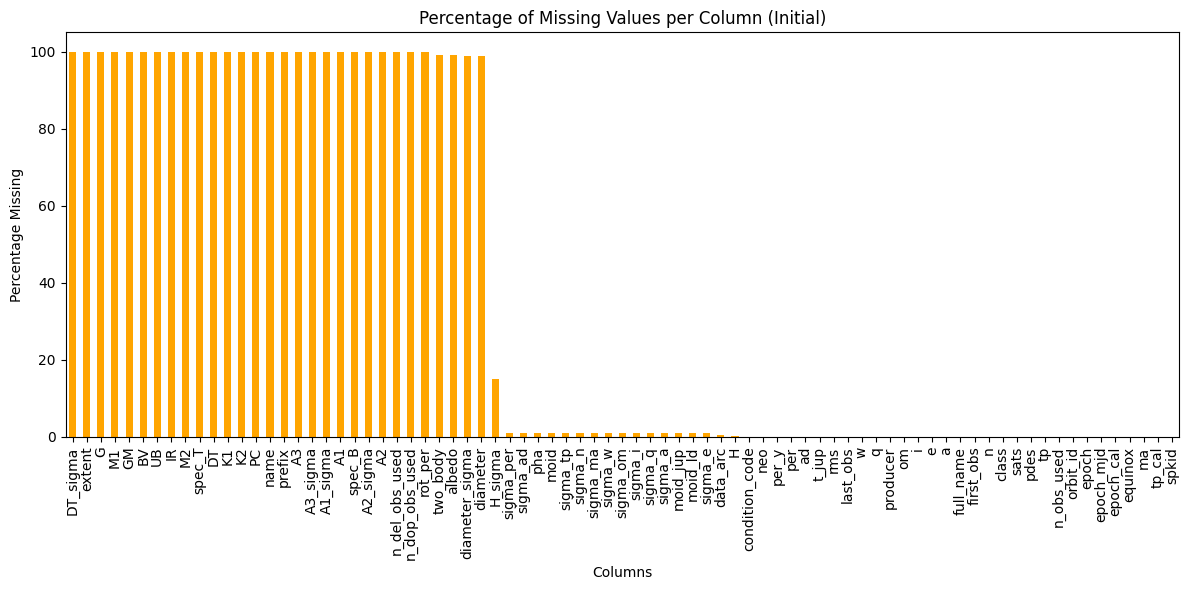

In [8]:
# Missing Values Summary
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
print("\nMissing Data Summary (Percentage of Missing Values):")
display(missing_summary)

# Plot Missing Values
plt.figure(figsize=(12,6))
missing_summary.plot(kind='bar', color='orange')
plt.title('Percentage of Missing Values per Column (Initial)')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.tight_layout()
plt.show()

In [9]:
# Value Counts for Categorical Columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    display(df[col].value_counts())


Value counts for spec_B:


spec_B
Sq    11
X      8
S      6
K      3
X:     3
Sk     3
Sr     2
C:     2
S:     2
T      2
V      1
Q      1
O      1
D      1
V:     1
Xc     1
Ch     1
L      1
Name: count, dtype: int64


Value counts for full_name:


full_name
(1927 LA)      1
(2018 QL27)    1
(2018 QN27)    1
(2018 QO27)    1
(2018 QP27)    1
              ..
(2014 SV67)    1
(2014 SX67)    1
(2014 SY67)    1
(2014 SE68)    1
(6344 P-L)     1
Name: count, Length: 677494, dtype: int64


Value counts for pdes:


pdes
1927 LA      1
2018 QL27    1
2018 QN27    1
2018 QO27    1
2018 QP27    1
            ..
2014 SV67    1
2014 SX67    1
2014 SY67    1
2014 SE68    1
6344 P-L     1
Name: count, Length: 677494, dtype: int64


Value counts for name:


name
'Oumuamua    1
Name: count, dtype: int64


Value counts for prefix:


prefix
A    4
Name: count, dtype: int64


Value counts for neo:


neo
N    644078
Y     33414
Name: count, dtype: int64


Value counts for pha:


pha
N    669535
Y      1606
Name: count, dtype: int64


Value counts for orbit_id:


orbit_id
JPL 1        145252
JPL 2         91909
JPL 3         70588
JPL 4         59693
JPL 5         50168
              ...  
JPL 146           1
E2024F93          1
JPL 112           1
MPO824474         1
MPO871924         1
Name: count, Length: 215, dtype: int64


Value counts for epoch_cal:


epoch_cal
2024-10-17.0000000    620662
2014-04-24.0000000      2088
2015-04-20.0000000      1687
2015-05-22.0000000      1507
2021-07-05.0000000      1200
                       ...  
2013-04-04.0000000         1
2013-04-08.0000000         1
2013-04-02.0000000         1
2013-04-21.0000000         1
2015-09-23.0000000         1
Name: count, Length: 5705, dtype: int64


Value counts for equinox:


equinox
J2000    677494
Name: count, dtype: int64


Value counts for tp_cal:


tp_cal
2024-09-17.1498123    2
2024-06-22.1523932    2
2026-02-08.7875470    2
2026-04-02.6347723    2
2025-12-25.6778730    2
                     ..
2023-06-26.5341875    1
2025-03-24.6342894    1
2024-08-20.3377369    1
2025-08-31.9051223    1
2026-09-21.9055072    1
Name: count, Length: 677482, dtype: int64


Value counts for class:


class
MBA    577360
OMB     21963
MCA     20448
APO     19034
IMB     17887
AMO     11719
TJN      6420
ATE      2637
IEO        24
HYA         2
Name: count, dtype: int64


Value counts for producer:


producer
Otto Matic           671072
MPCLINUX               4813
Pan                    1230
Veres                   235
Bell                     66
Giorgini                 51
Davide Farnocchia        19
Alexanders                5
Bardwell                  1
MPCW                      1
Williams                  1
Name: count, dtype: int64


Value counts for first_obs:


first_obs
2014-04-23    5452
2015-05-20    4297
2011-01-30    3841
2015-04-18    3615
2014-03-01    1705
              ... 
1999-05-12       1
2011-05-19       1
2016-05-23       1
2016-05-20       1
2024-12-01       1
Name: count, Length: 8621, dtype: int64


Value counts for last_obs:


last_obs
2023-12-04    7517
2024-10-24    7446
2024-10-30    7079
2024-10-31    6137
2023-12-08    4559
              ... 
2007-05-16       1
2007-05-19       1
2007-04-23       1
2007-04-15       1
2006-12-17       1
Name: count, Length: 6514, dtype: int64


Value counts for two_body:


two_body
F    6348
T       4
Name: count, dtype: int64

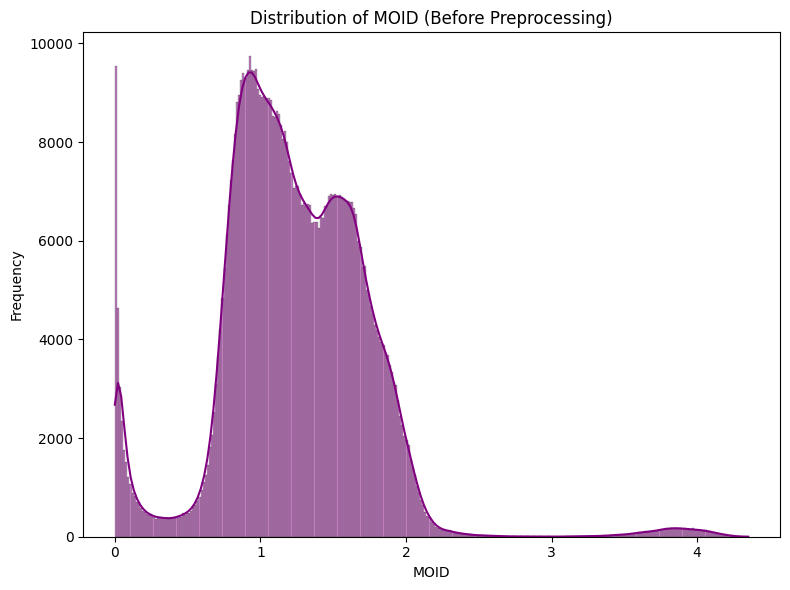

In [10]:
# Distribution of MOID (Before Preprocessing)
if 'moid' in df.columns:
    plt.figure(figsize=(8,6))
    sns.histplot(df['moid'].dropna(), kde=True, color='purple')
    plt.title('Distribution of MOID (Before Preprocessing)')
    plt.xlabel('MOID')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

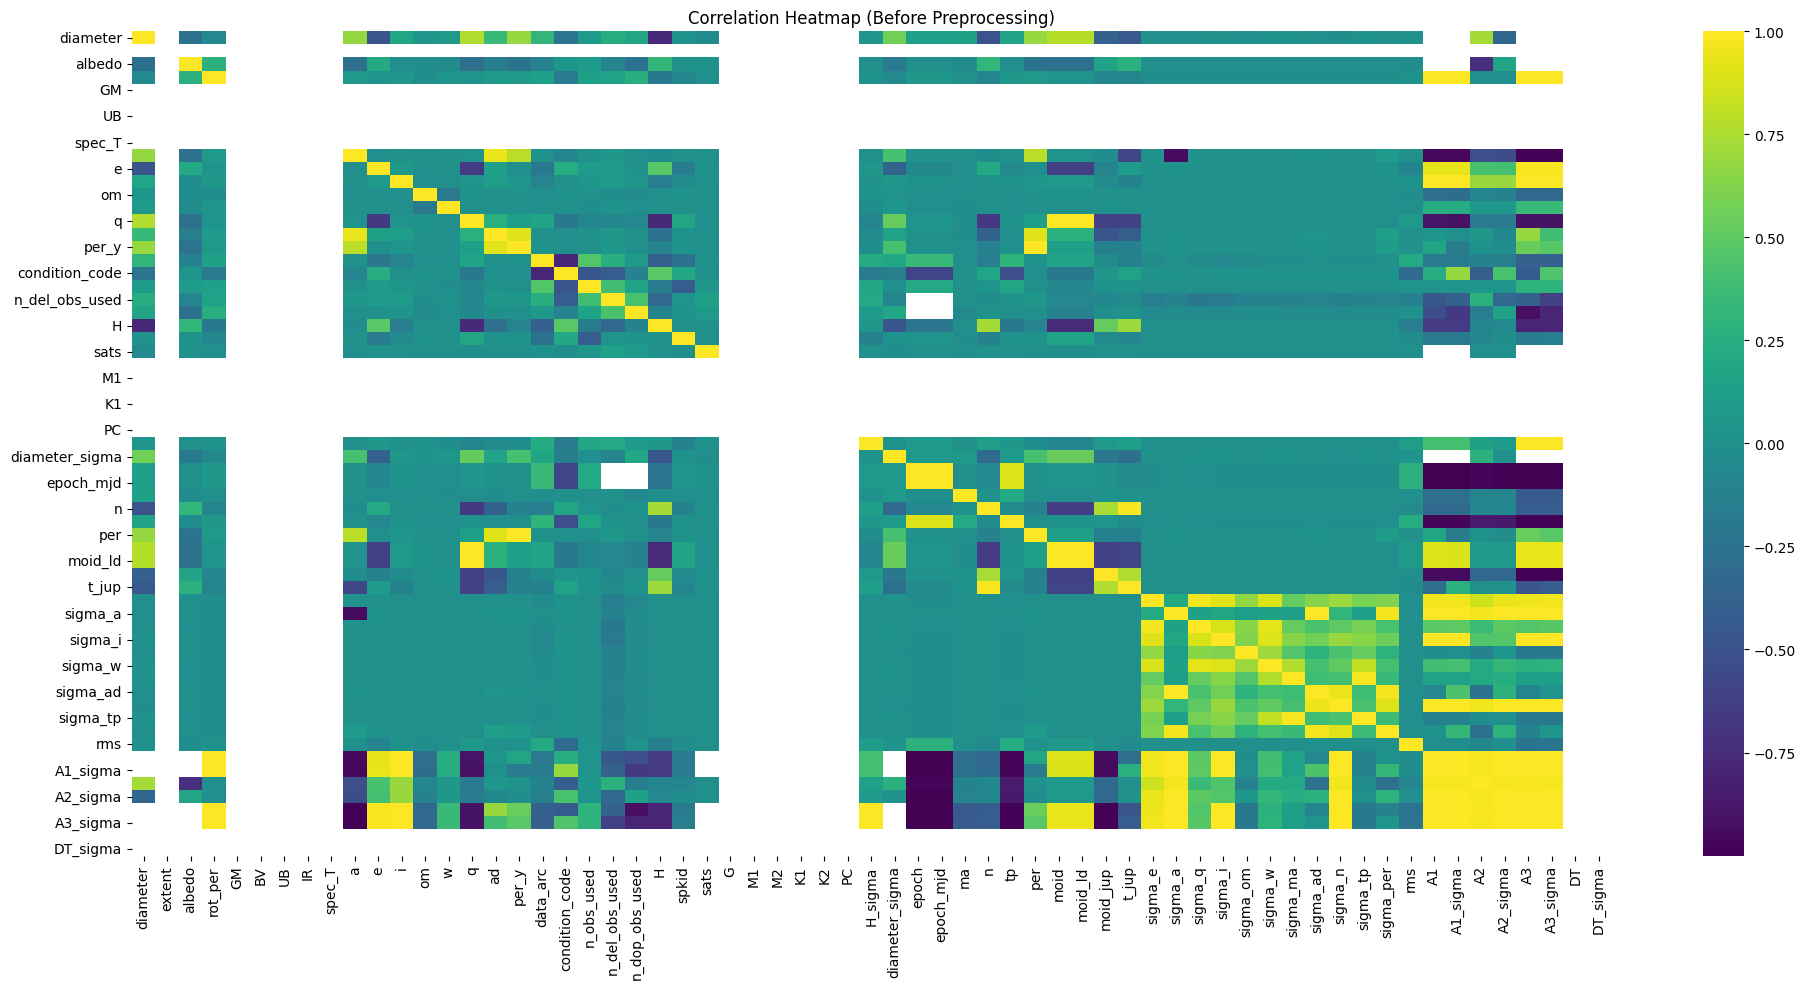

In [11]:
# Correlation Heatmap (Initial)
numeric_cols_initial = df.select_dtypes(include=[np.number]).columns
corr_initial = df[numeric_cols_initial].corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_initial, annot=False, cmap='viridis')
plt.title('Correlation Heatmap (Before Preprocessing)')
plt.tight_layout()
plt.show()

# 4.Data Preprocessing

## 4.1. Handle Missing Data

In [12]:
# Recalculate missing_summary after initial EDA
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0]
print("\nMissing Data Summary (Percentage of Missing Values):")
display(missing_summary)

# Drop columns with >90% missing values or irrelevant
cols_to_drop_missing = missing_summary[missing_summary > 90].index.tolist()
irrelevant_columns = ['producer', 'equinox', 'orbit_id', 'pdes', 'full_name', 'name', 'prefix']
cols_to_drop = list(set(cols_to_drop_missing + irrelevant_columns))

# Ensure columns exist before dropping
cols_to_drop = [col for col in cols_to_drop if col in df.columns]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print("\nDropped Columns:")
print(cols_to_drop)
logging.info(f"Dropped columns: {cols_to_drop}")

# Impute missing values in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
logging.info("Missing values imputed using mean strategy.")


Missing Data Summary (Percentage of Missing Values):


DT_sigma          100.000000
extent            100.000000
G                 100.000000
M1                100.000000
GM                100.000000
BV                100.000000
UB                100.000000
IR                100.000000
M2                100.000000
spec_T            100.000000
DT                100.000000
K1                100.000000
K2                100.000000
PC                100.000000
name               99.999852
prefix             99.999410
A3                 99.998967
A3_sigma           99.998967
A1_sigma           99.997491
A1                 99.997491
spec_B             99.992620
A2_sigma           99.976531
A2                 99.976531
n_del_obs_used     99.910700
n_dop_obs_used     99.910700
rot_per            99.801179
two_body           99.062427
albedo             99.040582
diameter_sigma     98.987002
diameter           98.986559
H_sigma            15.064635
sigma_per           0.937868
sigma_ad            0.937868
pha                 0.937720
moid                0.937573
sigma_tp            0.937573
sigma_n             0.937573
sigma_ma            0.937573
sigma_w             0.937573
sigma_om            0.937573
sigma_i             0.937573
sigma_q             0.937573
sigma_a             0.937573
moid_jup            0.937573
moid_ld             0.937573
sigma_e             0.937573
data_arc            0.392771
H                   0.146717
condition_code      0.001033
neo                 0.000295
per_y               0.000295
per                 0.000295
ad                  0.000295
t_jup               0.000295
rms                 0.000148
dtype: float64


Dropped Columns:
['IR', 'name', 'A1', 'full_name', 'spec_T', 'GM', 'A2_sigma', 'orbit_id', 'diameter_sigma', 'DT', 'M1', 'n_dop_obs_used', 'prefix', 'A3', 'n_del_obs_used', 'G', 'A1_sigma', 'pdes', 'DT_sigma', 'two_body', 'producer', 'BV', 'UB', 'A3_sigma', 'K1', 'extent', 'rot_per', 'A2', 'PC', 'albedo', 'diameter', 'spec_B', 'equinox', 'M2', 'K2']


## 4.2. Encode Binary Columns

In [13]:
# Map 'Y'/'N' to 1/0 in binary columns
binary_mapping = {'Y': 1, 'N': 0}
for col in ['neo', 'pha']:
    if col in df.columns:
        df[col] = df[col].map(binary_mapping)
        logging.info(f"Binary mapping applied to column: {col}")

## 4.3. Handle Date Columns

In [14]:
# Handle date columns
date_cols = ['epoch_cal', 'tp_cal', 'first_obs', 'last_obs']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df.drop(columns=[col], inplace=True)
        logging.info(f"Date column processed: {col}")

## 4.4. One-Hot Encode Categorical Columns

In [15]:
# One-hot encode categorical columns
remaining_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nRemaining Categorical Columns after Date conversion:", remaining_categorical_cols)

# One-hot encode the 'class' column if it exists
if 'class' in df.columns:
    df = pd.get_dummies(df, columns=['class'], prefix='class', drop_first=True)
    logging.info("One-hot encoding applied to 'class' column.")


Remaining Categorical Columns after Date conversion: ['class']


# 5.Feature Engineering

## 5.1. Add Derived Features

In [16]:
# Feature Engineering
GRAVITATIONAL_CONSTANT = 39.478  # AU^3 / yr^2

# Ensure required columns exist before creating derived features
if all(col in df.columns for col in ['q', 'a', 'e']):
    df['relative_orbital_distance'] = np.abs(df['q'] - df['a'] * (1 - df['e']))
    logging.info("Derived feature 'relative_orbital_distance' added.")
else:
    logging.warning("Required columns for 'relative_orbital_distance' not found.")

if 'a' in df.columns:
    df['orbital_velocity'] = np.sqrt(GRAVITATIONAL_CONSTANT / df['a'])
    logging.info("Derived feature 'orbital_velocity' added.")
else:
    logging.warning("Column 'a' not found. 'orbital_velocity' not created.")

if all(col in df.columns for col in ['e', 'a', 'q']):
    df['adjusted_eccentricity'] = df['e'] * df['a'] / df['q']
    logging.info("Derived feature 'adjusted_eccentricity' added.")
else:
    logging.warning("Required columns for 'adjusted_eccentricity' not found.")

## 5.2. Create Target Variable

In [17]:
# Create target variable
if 'moid' in df.columns:
    df['collision_risk'] = np.where(df['moid'] < 0.05, 1, 0)
    logging.info("'collision_risk' target variable created based on 'moid'.")
    # Drop 'moid' and 'moid_ld' to prevent data leakage
    features_to_drop = ['moid', 'moid_ld']
    features_to_drop = [col for col in features_to_drop if col in df.columns]
    df.drop(columns=features_to_drop, inplace=True, errors='ignore')
    logging.info(f"Dropped columns after target creation: {features_to_drop}")
else:
    logging.error("'moid' column not found. Cannot create 'collision_risk' target variable.")
    raise KeyError("'moid' column is missing from the dataset.")

# 6.Data Preparation for Modeling

## 6.1. Define Features and Target

In [18]:
# Define Features and Target
X = df.drop(columns=['collision_risk'])
y = df['collision_risk']

# Ensure only numeric features are used
X = X.select_dtypes(include=[np.number])
logging.info("Defined feature matrix X and target vector y.")

## 6.2. Split the Dataset

In [19]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
logging.info("Data split into training and testing sets.")

## 6.3. Handle Missing Values in Training and Testing Sets

In [20]:
# Identify columns with all missing values and drop them
all_missing_cols = X_train.columns[X_train.isnull().all()]
print("Columns with all missing values:", all_missing_cols.tolist())

X_train.drop(columns=all_missing_cols, inplace=True)
X_test.drop(columns=all_missing_cols, inplace=True)
logging.info(f"Dropped columns with all missing values: {all_missing_cols.tolist()}")

# Re-impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
logging.info("Re-imputed missing values in training and testing sets.")

# Verify no missing values remain
print("Missing Values in X_train:", X_train.isnull().sum().sum())
print("Missing Values in X_test:", X_test.isnull().sum().sum())

Columns with all missing values: ['epoch_cal_year', 'epoch_cal_month', 'epoch_cal_day', 'tp_cal_year', 'tp_cal_month', 'tp_cal_day']
Missing Values in X_train: 0
Missing Values in X_test: 0


## 6.4. Handle Class Imbalance with SMOTE

In [21]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
logging.info("Applied SMOTE to balance classes in the training set.")

print("Resampled Training Set Shape:", X_train_resampled.shape)

Resampled Training Set Shape: (1054508, 46)


## 6.5. Data Scaling

In [22]:
# Data Scaling
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
logging.info("Data scaling applied using StandardScaler.")

# Saving Scaler for future use
scaler_path = os.path.join(SAVE_DIR, "scaler.pkl")
joblib.dump(scaler, scaler_path)
logging.info(f"Scaler saved to: {scaler_path}")

## 6.6 Save feature names

In [23]:
# Save Feature Names
feature_names = X_train_resampled.columns.tolist()
feature_names_path = os.path.join(SAVE_DIR, "feature_names.pkl")
joblib.dump(feature_names, feature_names_path)
logging.info(f"Feature names saved to: {feature_names_path}")

Loaded Feature Names: ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'condition_code'] ...


In [27]:
# Load feature names to verify
loaded_feature_names = joblib.load(feature_names_path)
print("Loaded Feature Names:", loaded_feature_names[:10], "...")

Loaded Feature Names: ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'condition_code'] ...


# 7.Secondary Exploratory Data Analysis (Post-Preprocessing)

In [25]:
print("\n--- Secondary EDA (After Preprocessing) ---")
print("Post-Preprocessing X_train_resampled_scaled shape:", X_train_resampled_scaled.shape)
print("Class Distribution in y_train_resampled:\n", y_train_resampled.value_counts())


--- Secondary EDA (After Preprocessing) ---
Post-Preprocessing X_train_resampled_scaled shape: (1054508, 46)
Class Distribution in y_train_resampled:
 collision_risk
0    527254
1    527254
Name: count, dtype: int64


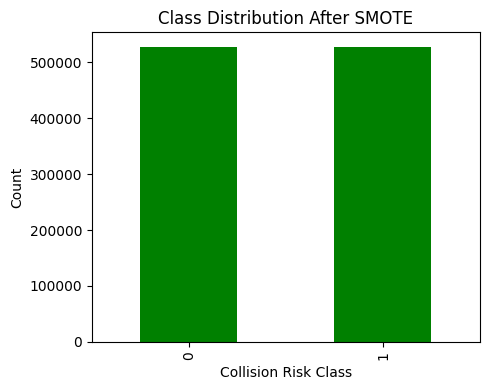

In [26]:
# Plot class distribution after SMOTE
plt.figure(figsize=(5,4))
y_train_resampled.value_counts().plot(kind='bar', color='green')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Collision Risk Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

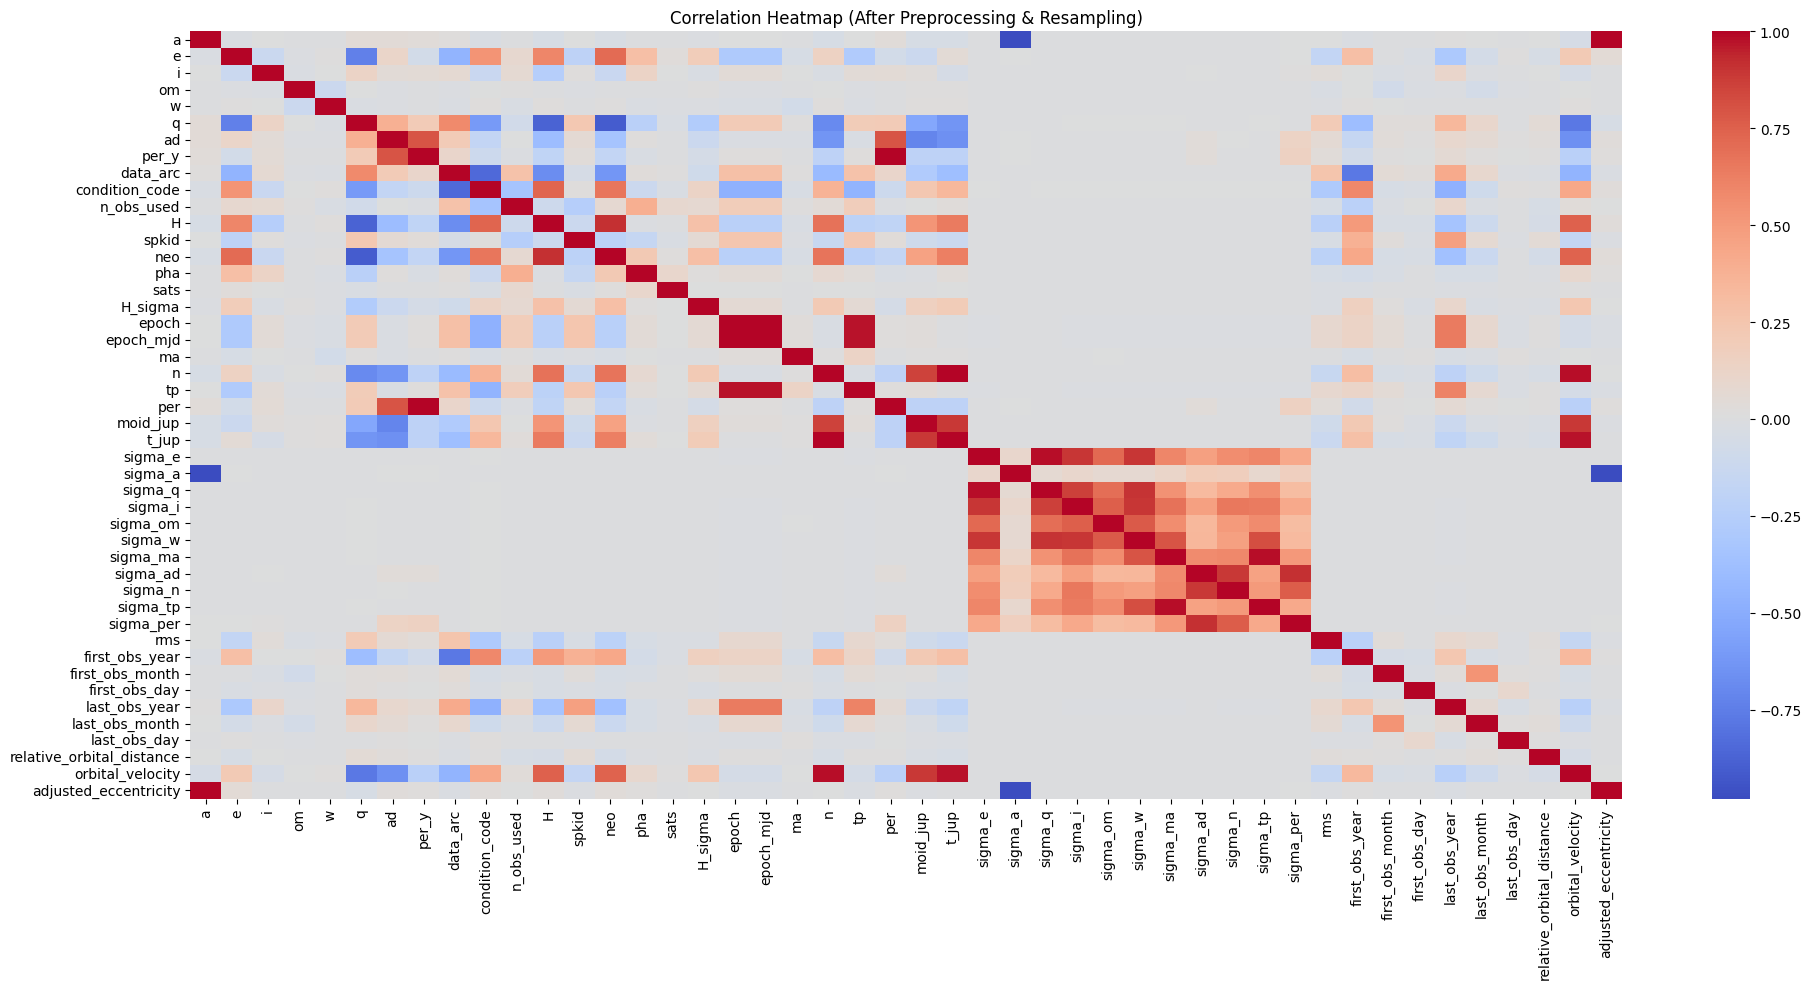

In [28]:
# Correlation Heatmap (After Preprocessing & Resampling)
X_train_post = pd.DataFrame(X_train_resampled_scaled, columns=X_train.columns)
corr_post = X_train_post.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_post, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (After Preprocessing & Resampling)')
plt.tight_layout()
plt.show()

# 8.Model Training and Evaluation

## 8.1 Random Forest Classifier

### 8.1.1 Training Random Forest

In [29]:
# Model save path
rf_model_path = os.path.join(SAVE_DIR, "random_forest_model.pkl")

print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
rf_model.fit(X_train_resampled_scaled, y_train_resampled)
logging.info("Random Forest model trained.")

# Save the model
joblib.dump(rf_model, rf_model_path)
print(f"Random Forest model saved at: {rf_model_path}")
logging.info(f"Random Forest model saved at: {rf_model_path}")


Training Random Forest Classifier...
Random Forest model saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/random_forest_model.pkl


### 8.1.2 Evaluate the Model

In [30]:
# Predictions and Evaluation for Random Forest
rf_y_pred = rf_model.predict(X_test_scaled)
rf_y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_prob)

print("\nRandom Forest Evaluation Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"ROC-AUC: {rf_roc_auc:.4f}")
logging.info("Random Forest evaluation completed.")


Random Forest Evaluation Metrics:
Accuracy: 0.9951
F1 Score: 0.9164
Precision: 0.8548
Recall: 0.9875
ROC-AUC: 0.9992


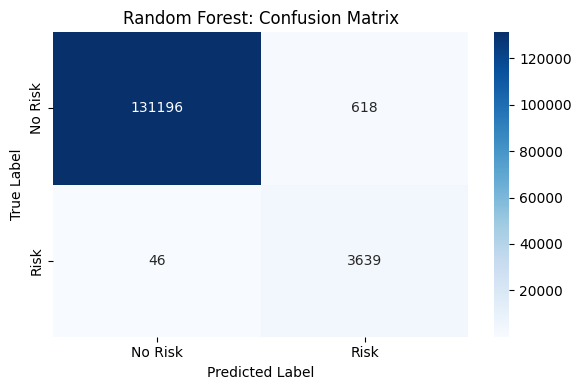

In [31]:
# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('Random Forest: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 8.2 XGBoost Classifier

### 8.2.1 Training XGBoost

In [32]:
# Define model save path
xgb_model_path = os.path.join(SAVE_DIR, "xgboost_model.pkl")

print("\nTraining XGBoost Classifier...")
xgb_model = XGBClassifier(
    use_label_encoder=False,
    random_state=RANDOM_SEED,
    eval_metric='logloss',
    n_estimators=500,
    n_jobs=-1
)
xgb_model.fit(X_train_resampled_scaled, y_train_resampled, verbose=False)
logging.info("XGBoost model trained.")

# Save the model
joblib.dump(xgb_model, xgb_model_path)
print(f"XGBoost model saved at: {xgb_model_path}")
logging.info(f"XGBoost model saved at: {xgb_model_path}")


Training XGBoost Classifier...
XGBoost model saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/xgboost_model.pkl


### 8.2.2 Evaluate the Model

In [33]:
# Predictions and Evaluation for XGBoost
xgb_y_pred = xgb_model.predict(X_test_scaled)
xgb_y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_y_prob)

print("\nXGBoost Evaluation Metrics:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"ROC-AUC: {xgb_roc_auc:.4f}")
logging.info("XGBoost evaluation completed.")


XGBoost Evaluation Metrics:
Accuracy: 0.9971
F1 Score: 0.9473
Precision: 0.9275
Recall: 0.9680
ROC-AUC: 0.9997


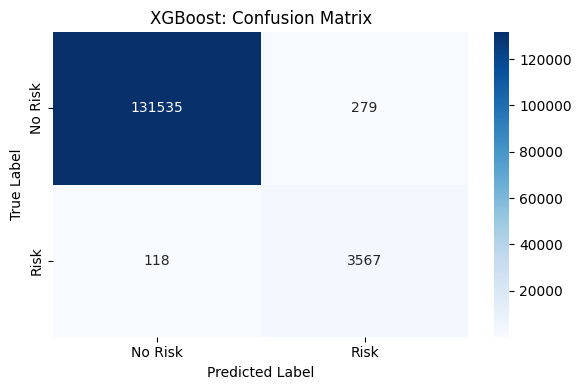

In [34]:
# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('XGBoost: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 8.3 Custom Neural Network(Dense)

### 8.3.1 Define the Model

In [36]:
# Define model save path
dense_model_filename = os.path.join(SAVE_DIR, "dense_model.h5")

print("\nTraining Custom Neural Network...")
def create_dense_model(input_dim):
    """
    Creates and compiles a custom neural network model.

    Parameters:
    - input_dim (int): Number of input features.

    Returns:
    - model (Sequential): Compiled Keras model.
    """
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

dense_model = create_dense_model(X_train_resampled_scaled.shape[1])


Training Custom Neural Network...


### 8.3.2 Training Neural Network

In [37]:
# Set Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = dense_model.fit(
    X_train_resampled_scaled,
    y_train_resampled,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
logging.info("Custom Neural Network trained.")

# Save Neural Network model
dense_model.save(dense_model_filename)
print(f"Neural Network model saved to: {dense_model_filename}")
logging.info(f"Neural Network model saved to: {dense_model_filename}")

Epoch 1/20
26363/26363 [==============================] - 54s 2ms/step - loss: 0.0230 - accuracy: 0.9933 - val_loss: 0.0062 - val_accuracy: 0.9998
Epoch 2/20
26363/26363 [==============================] - 53s 2ms/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 0.0103 - val_accuracy: 0.9990
Epoch 3/20
26363/26363 [==============================] - 52s 2ms/step - loss: 0.0157 - accuracy: 0.9955 - val_loss: 0.0091 - val_accuracy: 0.9998
Epoch 4/20
26363/26363 [==============================] - 52s 2ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.0089 - val_accuracy: 0.9995
Epoch 5/20
26363/26363 [==============================] - 53s 2ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.0055 - val_accuracy: 0.9998
Epoch 6/20
26363/26363 [==============================] - 53s 2ms/step - loss: 0.0142 - accuracy: 0.9959 - val_loss: 0.0078 - val_accuracy: 0.9996
Epoch 7/20
26363/26363 [==============================] - 52s 2ms/step - loss: 0.0153 - accuracy: 0.9959 - val_loss: 0

### 8.3.3. Evaluate the Model

In [38]:
# Predictions and Evaluation for Neural Network
dense_y_prob = dense_model.predict(X_test_scaled).flatten()
dense_y_pred = (dense_y_prob > 0.5).astype(int)

dense_accuracy = accuracy_score(y_test, dense_y_pred)
dense_f1 = f1_score(y_test, dense_y_pred)
dense_precision = precision_score(y_test, dense_y_pred)
dense_recall = recall_score(y_test, dense_y_pred)
dense_roc_auc = roc_auc_score(y_test, dense_y_prob)

print("\nCustom Neural Network Evaluation Metrics:")
print(f"Accuracy: {dense_accuracy:.4f}")
print(f"F1 Score: {dense_f1:.4f}")
print(f"Precision: {dense_precision:.4f}")
print(f"Recall: {dense_recall:.4f}")
print(f"ROC-AUC: {dense_roc_auc:.4f}")
logging.info("Custom Neural Network evaluation completed.")

4235/4235 [==============================] - 5s 1ms/step

Custom Neural Network Evaluation Metrics:
Accuracy: 0.9946
F1 Score: 0.9086
Precision: 0.8404
Recall: 0.9889
ROC-AUC: 0.9995


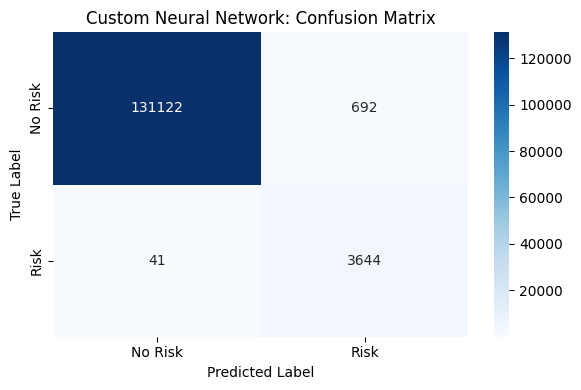

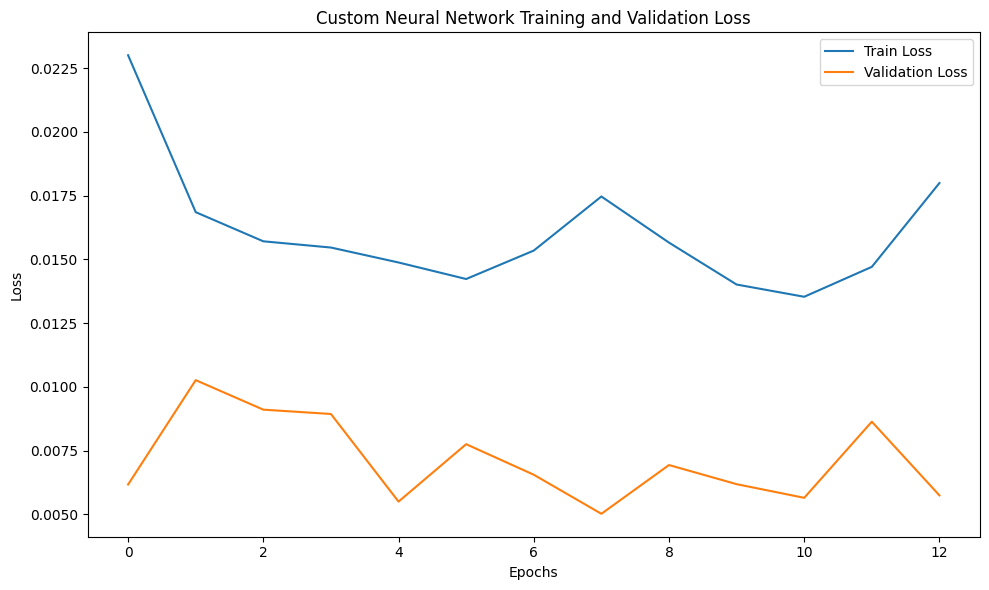

In [39]:
# Confusion Matrix for Neural Network
conf_matrix_nn = confusion_matrix(y_test, dense_y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('Custom Neural Network: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot Training History
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Custom Neural Network Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 9.Model Comparison

In [40]:
#Compile Evaluation Metrics
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Custom CNN'],
    'Accuracy': [rf_accuracy, xgb_accuracy, dense_accuracy],
    'F1 Score': [rf_f1, xgb_f1, dense_f1],
    'Precision': [rf_precision, xgb_precision, dense_precision],
    'Recall': [rf_recall, xgb_recall, dense_recall],
    'ROC-AUC': [rf_roc_auc, xgb_roc_auc, dense_roc_auc]
})

# Display the metrics
print(metrics_df)

           Model  Accuracy  F1 Score  Precision    Recall   ROC-AUC
0  Random Forest   0.99510  0.916394   0.854827  0.987517  0.999187
1        XGBoost   0.99707  0.947285   0.927457  0.967978  0.999749
2     Custom CNN   0.99459  0.908615   0.840406  0.988874  0.999454


In [41]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


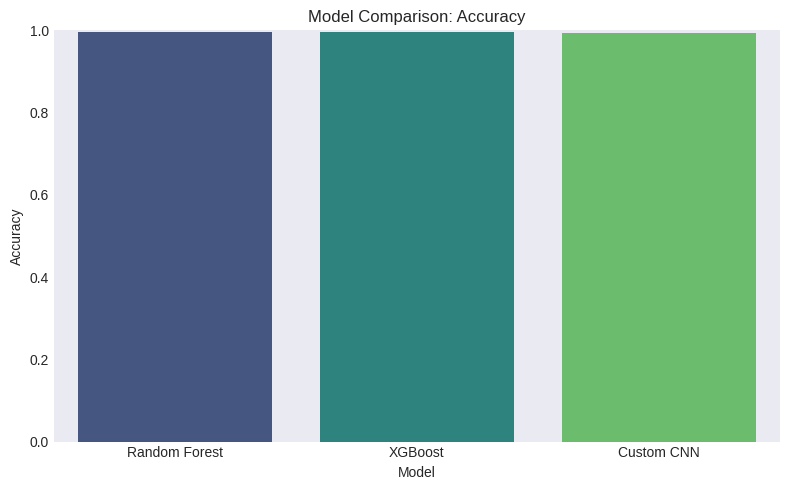

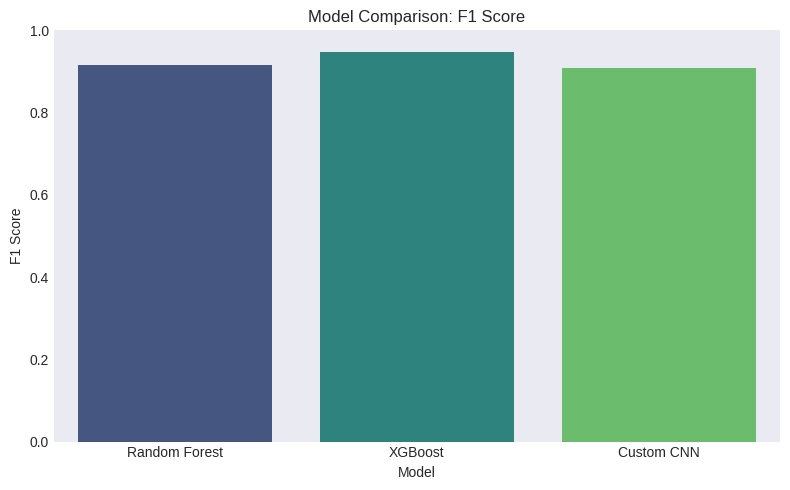

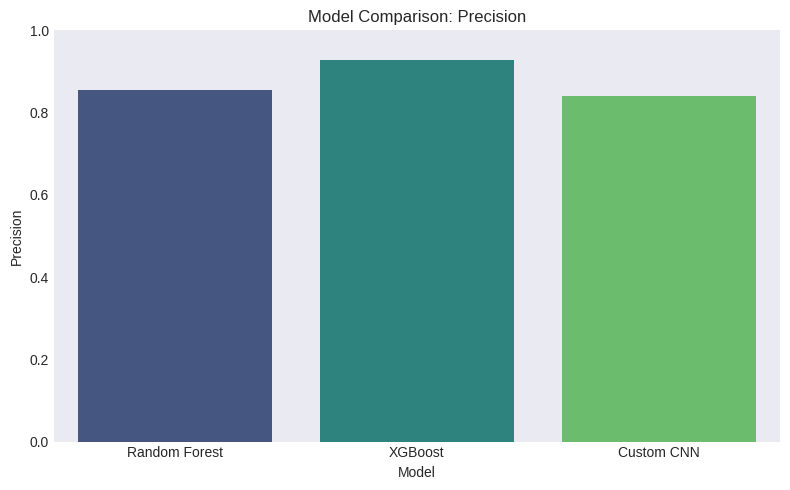

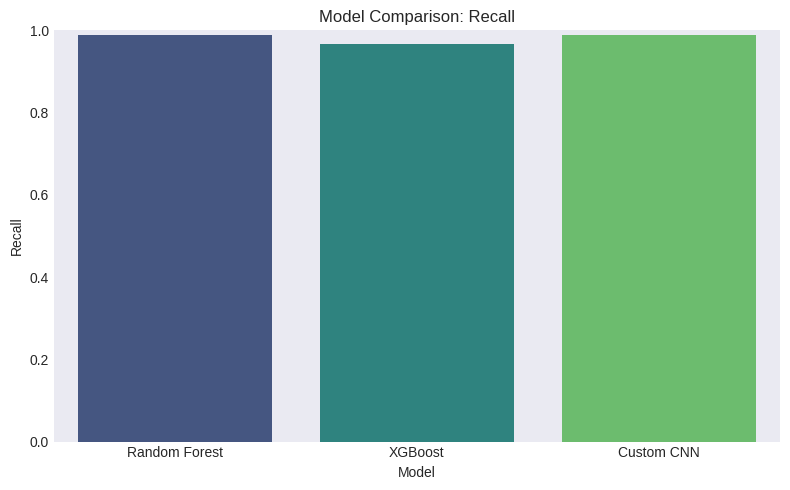

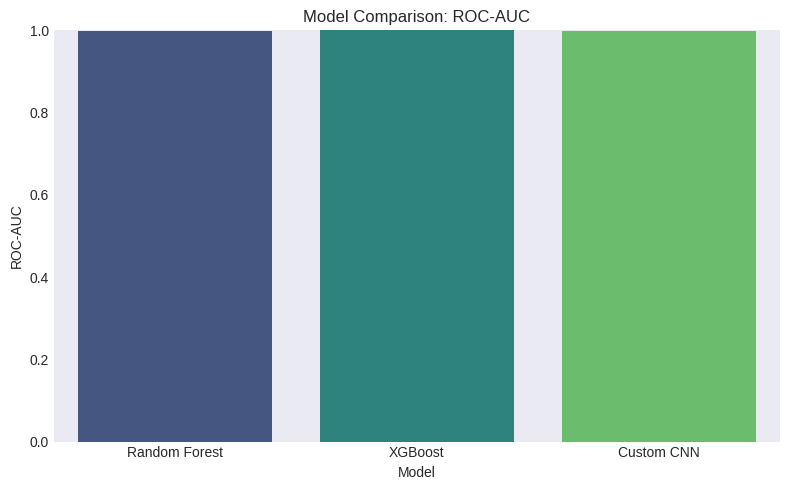

In [42]:
# Plot metrics comparison
plt.style.use('seaborn-v0_8-dark')

metrics_to_plot = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC-AUC']

for metric in metrics_to_plot:
    plt.figure(figsize=(8,5))
    sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
    plt.title(f'Model Comparison: {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

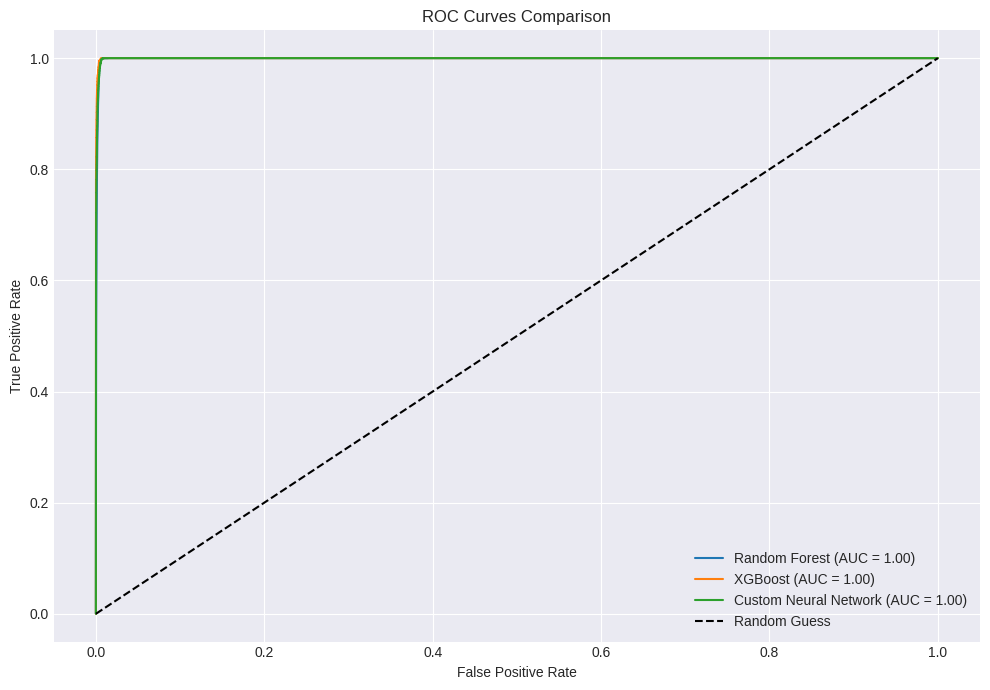

In [43]:
# Plot ROC Curves
plt.figure(figsize=(10, 7))

# Random Forest ROC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_prob)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')

# XGBoost ROC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_prob)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.2f})')

# Custom Neural Network ROC
dense_fpr, dense_tpr, _ = roc_curve(y_test, dense_y_prob)
plt.plot(dense_fpr, dense_tpr, label=f'Custom Neural Network (AUC = {dense_roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

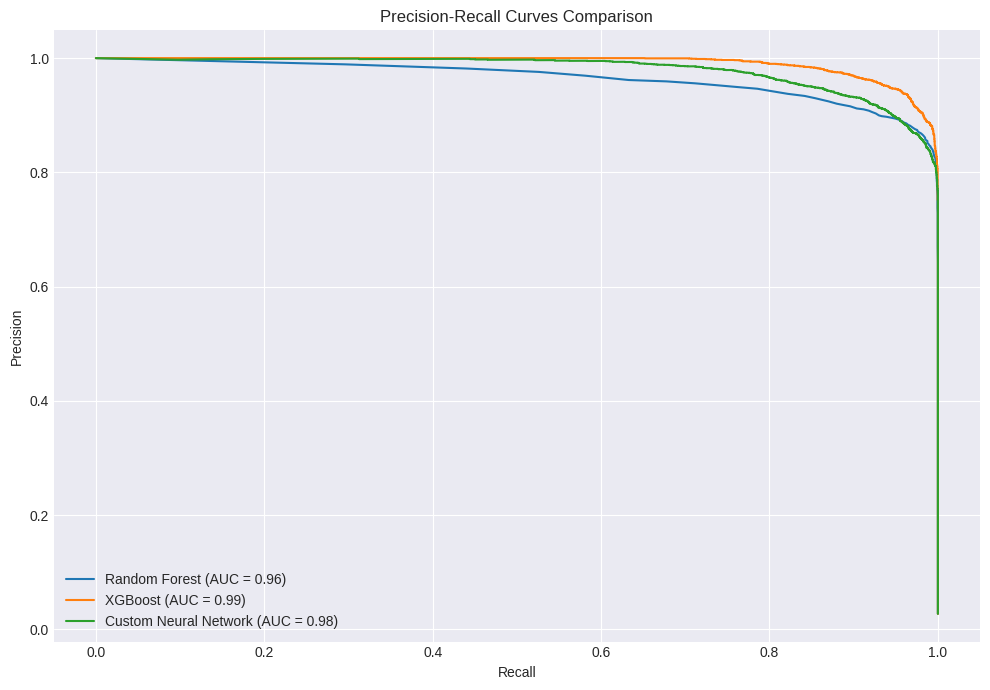

In [44]:
# Plot Precision-Recall Curves
plt.figure(figsize=(10, 7))

# Random Forest PR Curve
rf_precision_vals, rf_recall_vals, _ = precision_recall_curve(y_test, rf_y_prob)
rf_auc_pr = auc(rf_recall_vals, rf_precision_vals)
plt.plot(rf_recall_vals, rf_precision_vals, label=f'Random Forest (AUC = {rf_auc_pr:.2f})')

# XGBoost PR Curve
xgb_precision_vals, xgb_recall_vals, _ = precision_recall_curve(y_test, xgb_y_prob)
xgb_auc_pr = auc(xgb_recall_vals, xgb_precision_vals)
plt.plot(xgb_recall_vals, xgb_precision_vals, label=f'XGBoost (AUC = {xgb_auc_pr:.2f})')

# Custom Neural Network PR Curve
dense_precision_vals, dense_recall_vals, _ = precision_recall_curve(y_test, dense_y_prob)
dense_auc_pr = auc(dense_recall_vals, dense_precision_vals)
plt.plot(dense_recall_vals, dense_precision_vals, label=f'Custom Neural Network (AUC = {dense_auc_pr:.2f})')

# Plot settings
plt.title('Precision-Recall Curves Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

## 9.2 Feature Importance Comparison

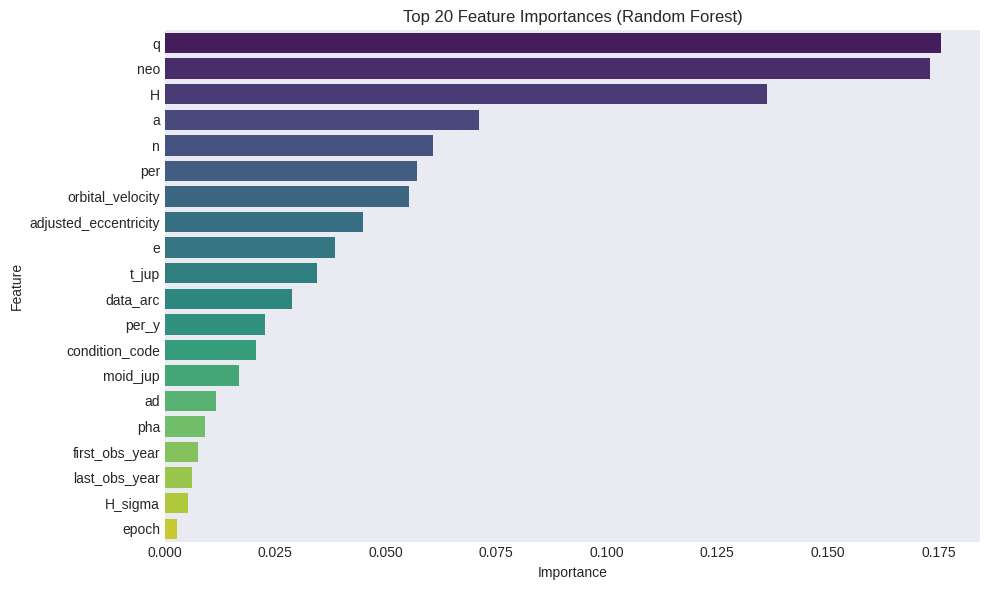

In [45]:
# Feature Importance Random Forest
importance_rf = rf_model.feature_importances_
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_rf
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_rf.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

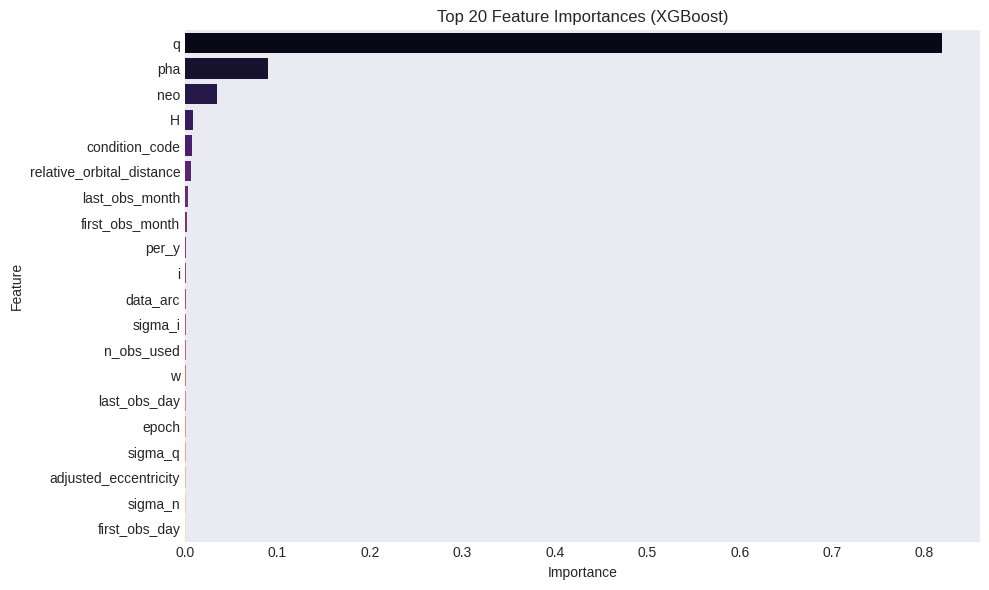

In [46]:
# Feature Importance XGBoost
importance_xgb = xgb_model.feature_importances_
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_xgb
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb.head(20), palette='magma')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [47]:
# Generate classification reports for each model
rf_class_report = classification_report(y_test, rf_y_pred, output_dict=True)
xgb_class_report = classification_report(y_test, xgb_y_pred, output_dict=True)
dense_class_report = classification_report(y_test, dense_y_pred, output_dict=True)

# Convert to DataFrames
rf_df_report = pd.DataFrame(rf_class_report).transpose()
xgb_df_report = pd.DataFrame(xgb_class_report).transpose()
dense_df_report = pd.DataFrame(dense_class_report).transpose()

# Add model names
rf_df_report['Model'] = 'Random Forest'
xgb_df_report['Model'] = 'XGBoost'
dense_df_report['Model'] = 'Custom Neural Network'

# Combine all reports
comparison_df = pd.concat([rf_df_report, xgb_df_report, dense_df_report], ignore_index=True)

# Reset index and rename columns
comparison_df.reset_index(inplace=True)
comparison_df.rename(columns={'index': 'Metric/Class'}, inplace=True)

# Display the combined classification report
print("\nClassification Report Comparison:")
display(comparison_df)


Classification Report Comparison:


Metric/Class  precision    recall  f1-score       support  \
0              0   0.999650  0.995312  0.997476  131814.00000   
1              1   0.854827  0.987517  0.916394    3685.00000   
2              2   0.995100  0.995100  0.995100       0.99510   
3              3   0.927238  0.991414  0.956935  135499.00000   
4              4   0.995711  0.995100  0.995271  135499.00000   
5              5   0.999104  0.997883  0.998493  131814.00000   
6              6   0.927457  0.967978  0.947285    3685.00000   
7              7   0.997070  0.997070  0.997070       0.99707   
8              8   0.963280  0.982931  0.972889  135499.00000   
9              9   0.997155  0.997070  0.997101  135499.00000   
10            10   0.999687  0.994750  0.997213  131814.00000   
11            11   0.840406  0.988874  0.908615    3685.00000   
12            12   0.994590  0.994590  0.994590       0.99459   
13            13   0.920047  0.991812  0.952914  135499.00000   
14            14   0.995356  0.994590  0.994803  135499.00000   

                    Model  
0           Random Forest  
1           Random Forest  
2           Random Forest  
3           Random Forest  
4           Random Forest  
5                 XGBoost  
6                 XGBoost  
7                 XGBoost  
8                 XGBoost  
9                 XGBoost  
10  Custom Neural Network  
11  Custom Neural Network  
12  Custom Neural Network  
13  Custom Neural Network  
14  Custom Neural Network

# 10.Monte Carlo Simulation with Edge Cases

## 10.1 Generate Edge Case Data

In [48]:
def monte_carlo_extended_cases_v2(model, X_test, feature_columns, n_simulations=100, model_type="Random Forest"):
    """
    Monte Carlo Simulation with Extended Edge Cases tailored to orbital dynamics and collision risks.

    Parameters:
    - model: Trained model for predictions
    - X_test: Test data (scaled as NumPy array)
    - feature_columns: List of feature names in the dataset
    - n_simulations: Number of simulations for each edge case
    - model_type: Type of the model (for handling Neural Network predictions)

    Returns:
    - Results: Dictionary of predictions for each edge case
    """
    # Convert X_test to DataFrame
    X_test_df = pd.DataFrame(X_test, columns=feature_columns)

    # Initialize results dictionary
    results = {}

    # Extended Edge Cases aligned with available features
    extended_conditions = {
        "extreme_eccentricity": lambda df: df.assign(e=0.99) if 'e' in df.columns else df,
        "high_velocity": lambda df: df.assign(orbital_velocity=df['orbital_velocity'] * 1.5) if 'orbital_velocity' in df.columns else df,
        "low_velocity": lambda df: df.assign(orbital_velocity=df['orbital_velocity'] * 0.5) if 'orbital_velocity' in df.columns else df,
        "proximity_to_earth": lambda df: df.assign(q=0.01) if 'q' in df.columns else df,
        "distant_orbit": lambda df: df.assign(q=100.0) if 'q' in df.columns else df,
        "low_observation_arc": lambda df: df.assign(arc_length=10) if 'arc_length' in df.columns else df,
        "perturbed_inclination": lambda df: df.assign(i=df['i'] + np.random.normal(0, 5)) if 'i' in df.columns else df,
        "aligned_orbit": lambda df: df.assign(i=0) if 'i' in df.columns else df,
        "large_orbit_uncertainty": lambda df: df.assign(
            sigma_a=df['a'] * 0.2 if 'a' in df.columns else 0,
            sigma_e=df['e'] * 0.2 if 'e' in df.columns else 0,
            sigma_i=df['i'] * 0.2 if 'i' in df.columns else 0
        ) if all(col in df.columns for col in ['a', 'e', 'i']) else df,
    }

    for condition, modifier in extended_conditions.items():
        simulated_data = []
        for _ in range(n_simulations):
            try:
                # Apply the condition modifier
                perturbed_data = modifier(X_test_df).copy()
            except KeyError as e:
                logging.warning(f"KeyError for condition '{condition}': {e}. Skipping.")
                continue
            except Exception as e:
                logging.error(f"Unexpected error for condition '{condition}': {e}. Skipping.")
                continue

            # Ensure perturbed data matches the original feature set
            perturbed_data = perturbed_data[feature_columns]

            # Add random noise for perturbation
            for col in feature_columns:
                if np.issubdtype(perturbed_data[col].dtype, np.number):
                    perturbation = np.random.normal(0, 0.01 * perturbed_data[col].std())
                    perturbed_data[col] += perturbation

            # Predict probabilities
            try:
                if isinstance(model, Sequential):
                    # For Neural Network
                    y_prob = model.predict(perturbed_data).flatten()
                else:
                    # For scikit-learn models
                    y_prob = model.predict_proba(perturbed_data)[:, 1]
                simulated_data.append(y_prob)
            except Exception as e:
                logging.error(f"Error during prediction for condition '{condition}': {e}")
                continue

        # Store results for the edge case
        if simulated_data:  # Avoid storing empty results
            results[condition] = pd.DataFrame(simulated_data).T

    return results

## 10.2 Perform Monte Carlo Simulations

### 10.2.1 Random Forest Simulation

In [49]:
# Perform Monte Carlo Simulation for Random Forest
print("\nRunning Monte Carlo Simulations for Random Forest...")
rf_edge_case_results = monte_carlo_extended_cases_v2(
    model=rf_model,
    X_test=X_test_scaled,
    feature_columns=X_test.columns,
    n_simulations=100,
    model_type="Random Forest"
)

# Save the Random Forest Monte Carlo results
rf_save_path = os.path.join(SAVE_DIR, "rf_monte_carlo_results_v2.pkl")
joblib.dump(rf_edge_case_results, rf_save_path)
print(f"Random Forest Monte Carlo results saved at: {rf_save_path}")
logging.info(f"Random Forest Monte Carlo results saved at: {rf_save_path}")


Running Monte Carlo Simulations for Random Forest...
Random Forest Monte Carlo results saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/rf_monte_carlo_results_v2.pkl



Random Forest Edge Case: extreme_eccentricity
Mean Predictions: count    135499.000000
mean          0.031710
std           0.129263
min           0.000000
25%           0.002600
50%           0.005600
75%           0.007400
max           0.926500
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.009283
std           0.015417
min           0.000000
25%           0.004408
50%           0.005945
75%           0.008147
max           0.201215
dtype: float64


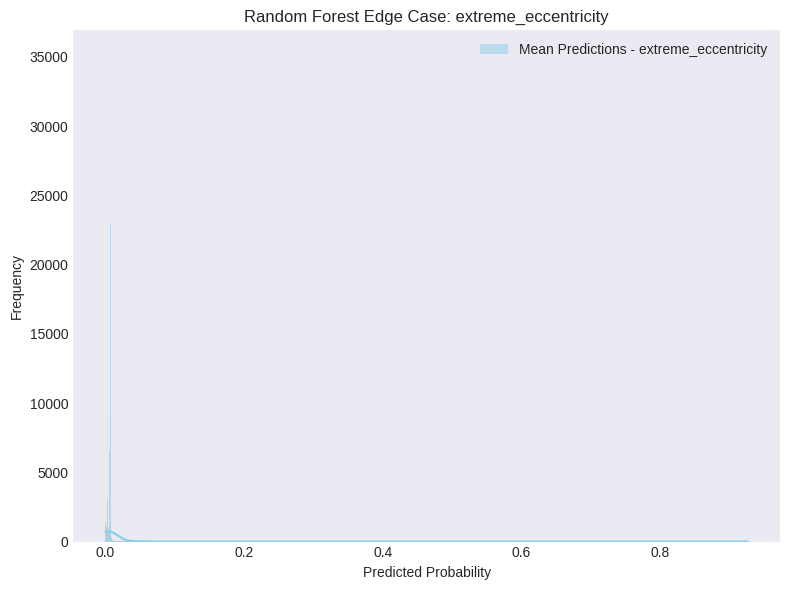


Random Forest Edge Case: high_velocity
Mean Predictions: count    135499.000000
mean          0.029092
std           0.129868
min           0.000000
25%           0.000200
50%           0.004500
75%           0.005100
max           0.927800
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.007330
std           0.016097
min           0.000000
25%           0.001407
50%           0.005009
75%           0.005588
max           0.198279
dtype: float64


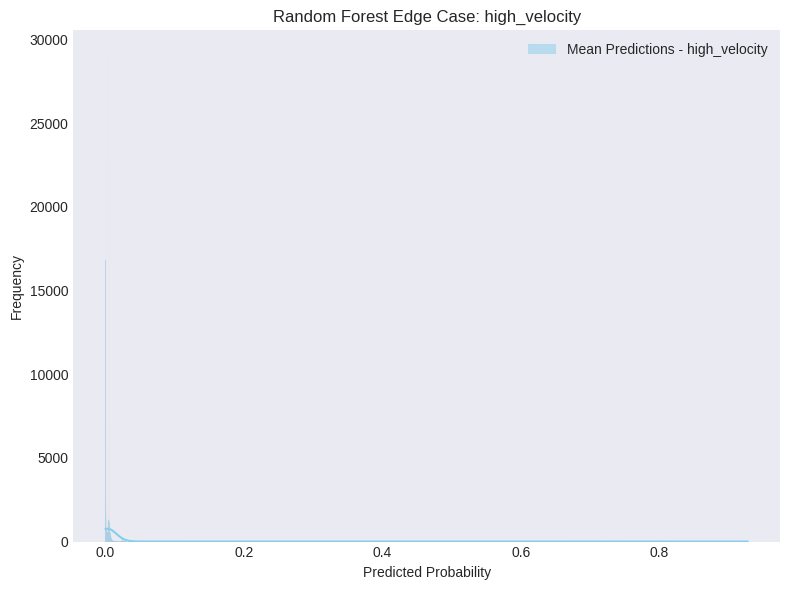


Random Forest Edge Case: low_velocity
Mean Predictions: count    135499.000000
mean          0.035716
std           0.129950
min           0.000000
25%           0.000300
50%           0.004700
75%           0.020900
max           0.948200
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.007958
std           0.016275
min           0.000000
25%           0.001714
50%           0.005009
75%           0.006371
max           0.194289
dtype: float64


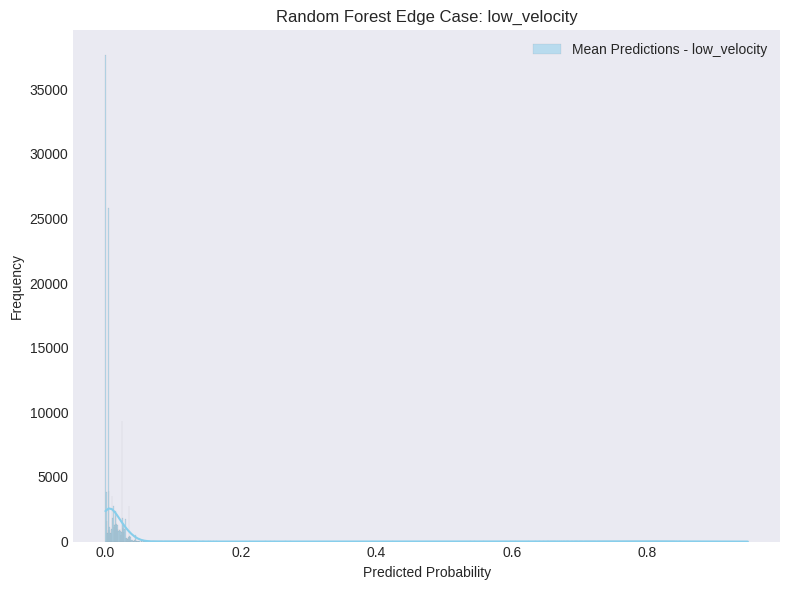


Random Forest Edge Case: proximity_to_earth
Mean Predictions: count    135499.000000
mean          0.012359
std           0.046586
min           0.000000
25%           0.000000
50%           0.004100
75%           0.004600
max           0.664100
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.005152
std           0.007593
min           0.000000
25%           0.000000
50%           0.004989
75%           0.005207
max           0.077333
dtype: float64


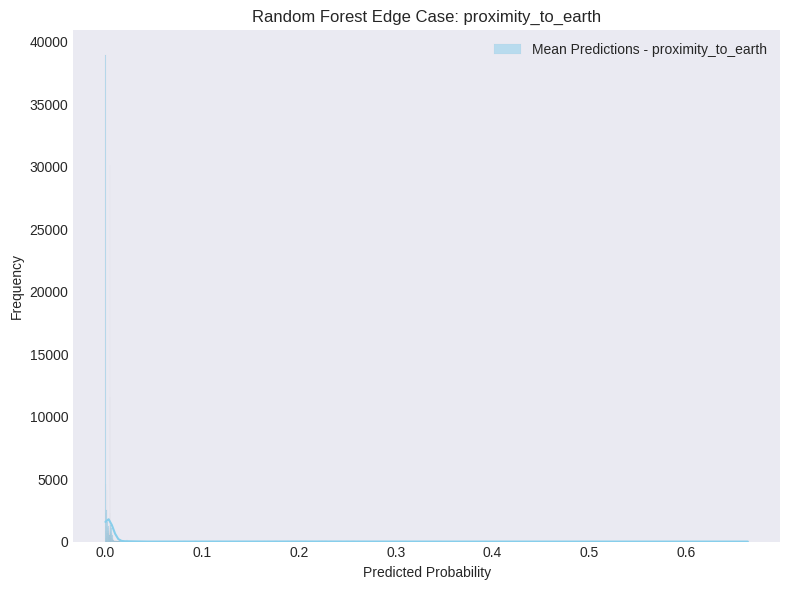


Random Forest Edge Case: distant_orbit
Mean Predictions: count    135499.000000
mean          0.012731
std           0.046770
min           0.000000
25%           0.000100
50%           0.004600
75%           0.005200
max           0.661700
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.005397
std           0.007475
min           0.000000
25%           0.001000
50%           0.005024
75%           0.005218
max           0.082289
dtype: float64


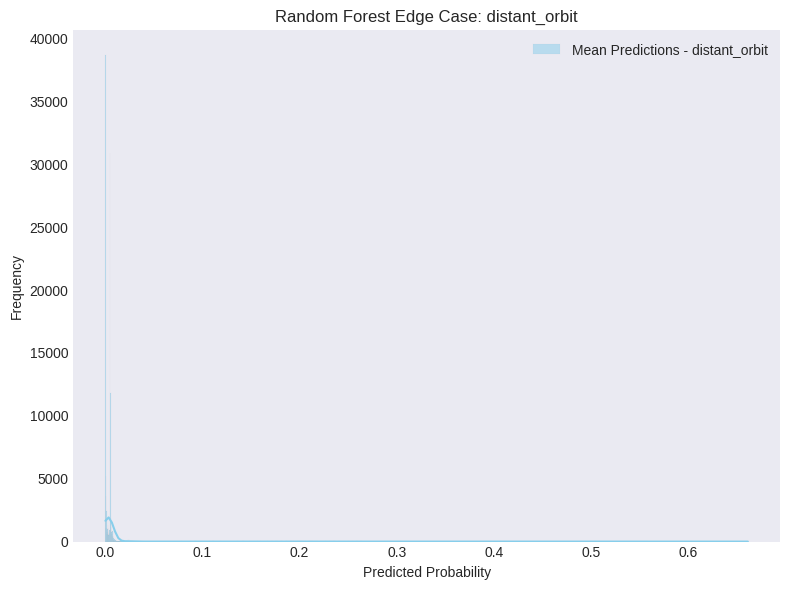


Random Forest Edge Case: low_observation_arc
Mean Predictions: count    135499.000000
mean          0.029510
std           0.133419
min           0.000000
25%           0.000100
50%           0.004200
75%           0.004600
max           0.954000
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.007167
std           0.016036
min           0.000000
25%           0.001000
50%           0.004960
75%           0.005207
max           0.195355
dtype: float64


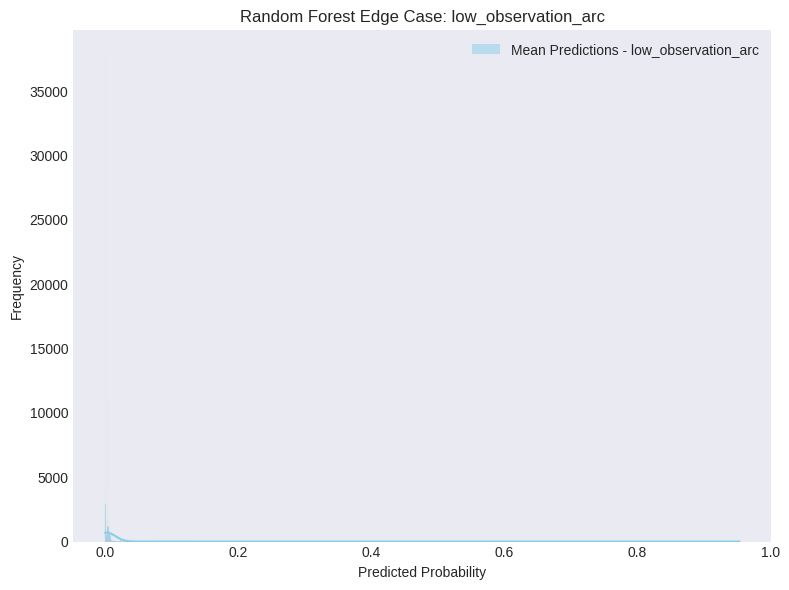


Random Forest Edge Case: perturbed_inclination
Mean Predictions: count    135499.000000
mean          0.028065
std           0.123601
min           0.000000
25%           0.002500
50%           0.002700
75%           0.003300
max           0.927800
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.009885
std           0.022452
min           0.000000
25%           0.004408
50%           0.004894
75%           0.005730
max           0.189701
dtype: float64


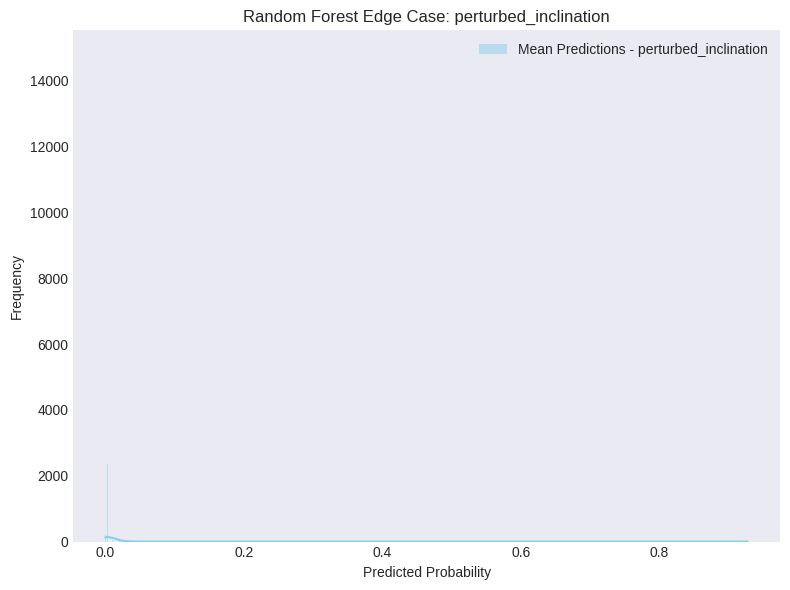


Random Forest Edge Case: aligned_orbit
Mean Predictions: count    135499.000000
mean          0.028169
std           0.132917
min           0.000000
25%           0.000300
50%           0.000400
75%           0.001900
max           0.946700
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.006502
std           0.016766
min           0.000000
25%           0.001714
50%           0.001969
75%           0.004353
max           0.209188
dtype: float64


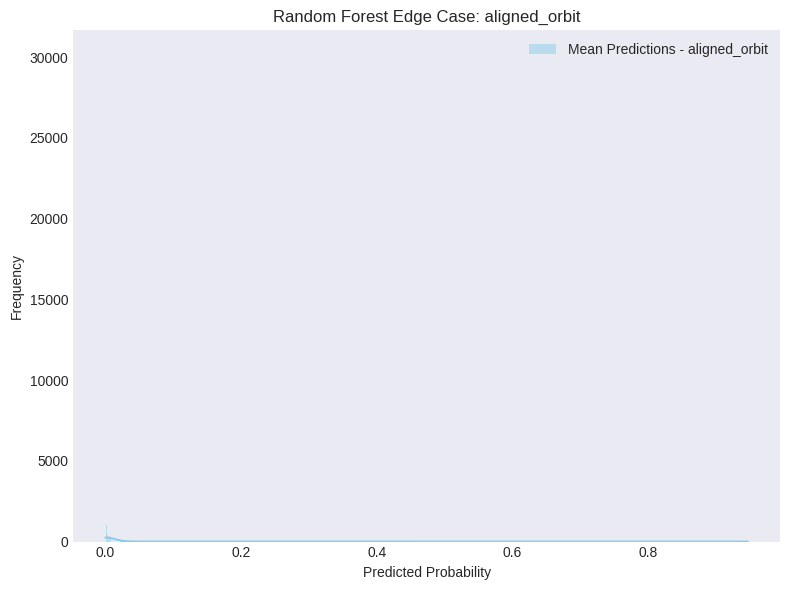


Random Forest Edge Case: large_orbit_uncertainty
Mean Predictions: count    135499.000000
mean          0.029671
std           0.133722
min           0.000000
25%           0.000100
50%           0.004200
75%           0.004600
max           0.951600
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.006730
std           0.013735
min           0.000000
25%           0.001000
50%           0.004960
75%           0.005573
max           0.199714
dtype: float64


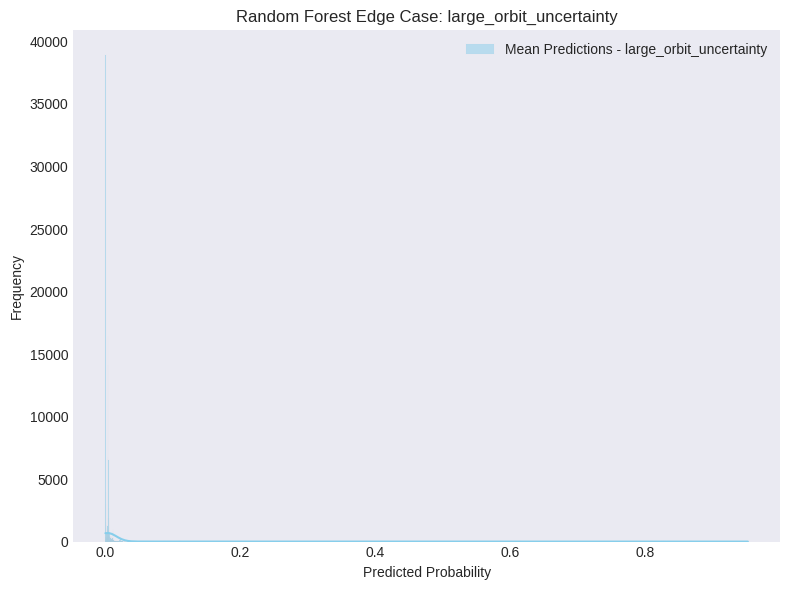

In [50]:
# Analyze Results for Random Forest
for condition, result in rf_edge_case_results.items():
    mean_predictions = result.mean(axis=1)
    std_predictions = result.std(axis=1)
    print(f"\nRandom Forest Edge Case: {condition}")
    print(f"Mean Predictions: {mean_predictions.describe()}")
    print(f"Prediction Standard Deviations: {std_predictions.describe()}")

    # Visualize Mean Predictions
    plt.figure(figsize=(8, 6))
    sns.histplot(mean_predictions, kde=True, label=f'Mean Predictions - {condition}', color='skyblue')
    plt.title(f'Random Forest Edge Case: {condition}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

### 10.2.2 XGBoost Simulation

In [51]:
# Perform Monte Carlo Simulation for XGBoost
print("\nRunning Monte Carlo Simulations for XGBoost...")
xgb_edge_case_results = monte_carlo_extended_cases_v2(
    model=xgb_model,
    X_test=X_test_scaled,
    feature_columns=X_test.columns,
    n_simulations=100,
    model_type="XGBoost"
)

# Save the XGBoost Monte Carlo results
xgb_save_path = os.path.join(SAVE_DIR, "xgb_monte_carlo_results_v2.pkl")
joblib.dump(xgb_edge_case_results, xgb_save_path)
print(f"XGBoost Monte Carlo results saved at: {xgb_save_path}")
logging.info(f"XGBoost Monte Carlo results saved at: {xgb_save_path}")


Running Monte Carlo Simulations for XGBoost...
XGBoost Monte Carlo results saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/xgb_monte_carlo_results_v2.pkl


In [ ]:
# Analyze Results for XGBoost
for condition, result in xgb_edge_case_results.items():
    mean_predictions = result.mean(axis=1)
    std_predictions = result.std(axis=1)
    print(f"\nXGBoost Edge Case: {condition}")
    print(f"Mean Predictions: {mean_predictions.describe()}")
    print(f"Prediction Standard Deviations: {std_predictions.describe()}")

    # Visualize Mean Predictions
    plt.figure(figsize=(8, 6))
    sns.histplot(mean_predictions, kde=True, label=f'Mean Predictions - {condition}', color='salmon')
    plt.title(f'XGBoost Edge Case: {condition}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


XGBoost Edge Case: extreme_eccentricity
Mean Predictions: count    1.354990e+05
mean     2.674967e-02
std      1.488006e-01
min      2.308455e-12
25%      1.614712e-08
50%      1.038741e-07
75%      7.937361e-07
max      9.999998e-01
dtype: float64
Prediction Standard Deviations: count    1.354990e+05
mean     8.246469e-03
std      4.967459e-02
min      5.175090e-12
25%      5.627044e-08
50%      3.868048e-07
75%      3.194586e-06
max      4.656827e-01
dtype: float64


## 10.3 Feature Importance Analysis for Edge Cases

In [24]:
import joblib
from tensorflow.keras.models import load_model

# Define the directory where your models are saved
save_dir = "/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics"

# Load Random Forest model
rf_model_path = f"{save_dir}/random_forest_model.pkl"
rf_model = joblib.load(rf_model_path)
print("Random Forest model loaded.")

# Load XGBoost model
xgb_model_path = f"{save_dir}/xgboost_model.pkl"
xgb_model = joblib.load(xgb_model_path)
print("XGBoost model loaded.")

# Load Neural Network model
nn_model_path = f"{save_dir}/dense_model.h5"
nn_model = load_model(nn_model_path)
print("Neural Network model loaded.")

# Verify successful loading
print("All models loaded successfully!")

Random Forest model loaded.
XGBoost model loaded.


Neural Network model loaded.
All models loaded successfully!


In [28]:
import joblib
import os

# Define the directory where the Monte Carlo results are saved
SAVE_DIR = "/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics"

# Load the Random Forest Monte Carlo results
rf_save_path = os.path.join(SAVE_DIR, "rf_monte_carlo_results_v2.pkl")
rf_edge_case_results = joblib.load(rf_save_path)
print(f"Random Forest Monte Carlo results loaded from: {rf_save_path}")

# Load the XGBoost Monte Carlo results
xgb_save_path = os.path.join(SAVE_DIR, "xgb_monte_carlo_results_v2.pkl")
xgb_edge_case_results = joblib.load(xgb_save_path)
print(f"XGBoost Monte Carlo results loaded from: {xgb_save_path}")

Random Forest Monte Carlo results loaded from: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/rf_monte_carlo_results_v2.pkl
XGBoost Monte Carlo results loaded from: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/xgb_monte_carlo_results_v2.pkl


### 10.3.1 Define the Analysis Function

In [29]:
def feature_importance_analysis(edge_case_results, model_type, feature_columns, save_dir):
    """
    Analyze and visualize feature importance for edge cases.

    Parameters:
    - edge_case_results: Dictionary of Monte Carlo results for edge cases.
    - model_type: String, type of model ("Random Forest" or "XGBoost").
    - feature_columns: List of feature names in the dataset.
    - save_dir: Directory to save plots.
    """
    for condition, result in edge_case_results.items():
        # Aggregate results for the condition
        mean_predictions = result.mean(axis=1)

        # Calculate feature importance
        if model_type == "Random Forest":
            importance = rf_model.feature_importances_
        elif model_type == "XGBoost":
            importance = xgb_model.feature_importances_
        else:
            logging.error(f"Unsupported model type: {model_type}")
            continue

        # Create DataFrame for importance
        feature_importance_df = pd.DataFrame({
            'Feature': feature_columns,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)

        # Plot Top 20 Feature Importances
        plt.figure(figsize=(10,6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
        plt.title(f"Feature Importance for {model_type} - Edge Case: {condition}")
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()

        # Save the plot
        plot_save_path = os.path.join(
            save_dir, f"{model_type.replace(' ', '_').lower()}_importance_{condition}.png"
        )
        plt.savefig(plot_save_path)
        plt.show()
        logging.info(f"Feature importance plot saved at: {plot_save_path}")


Analyzing Feature Importance for Random Forest Edge Cases...


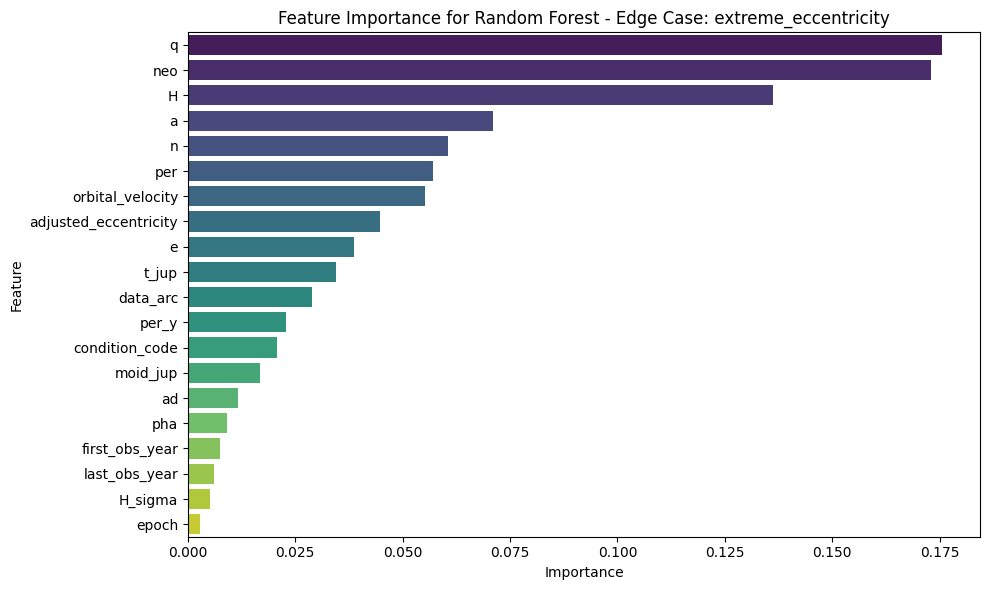

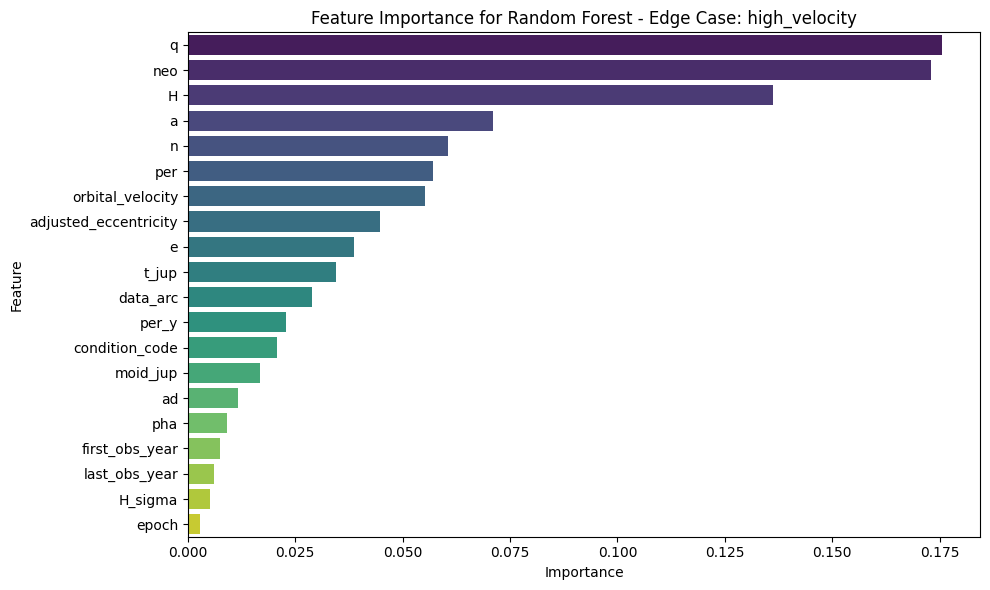

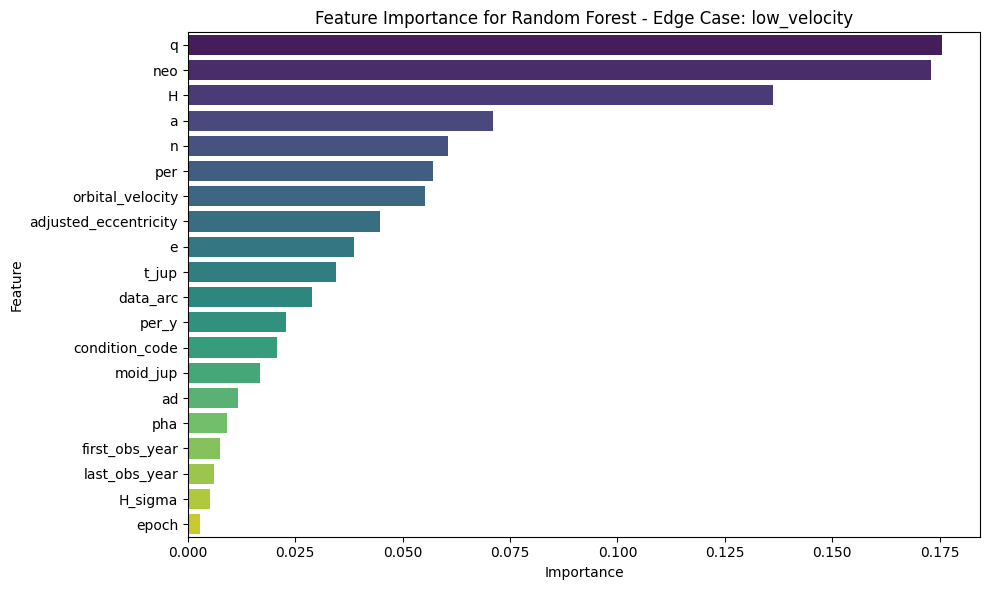

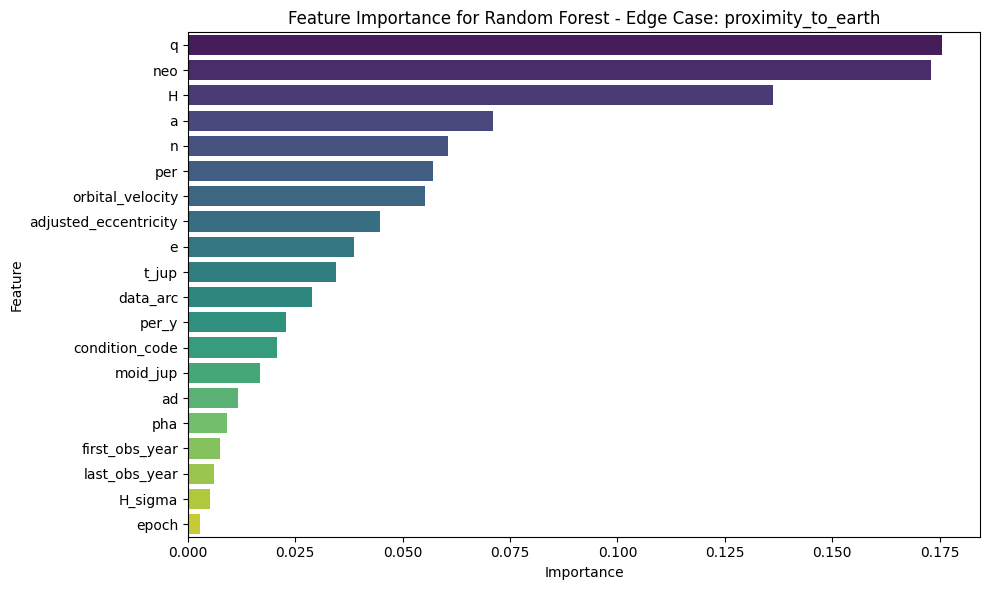

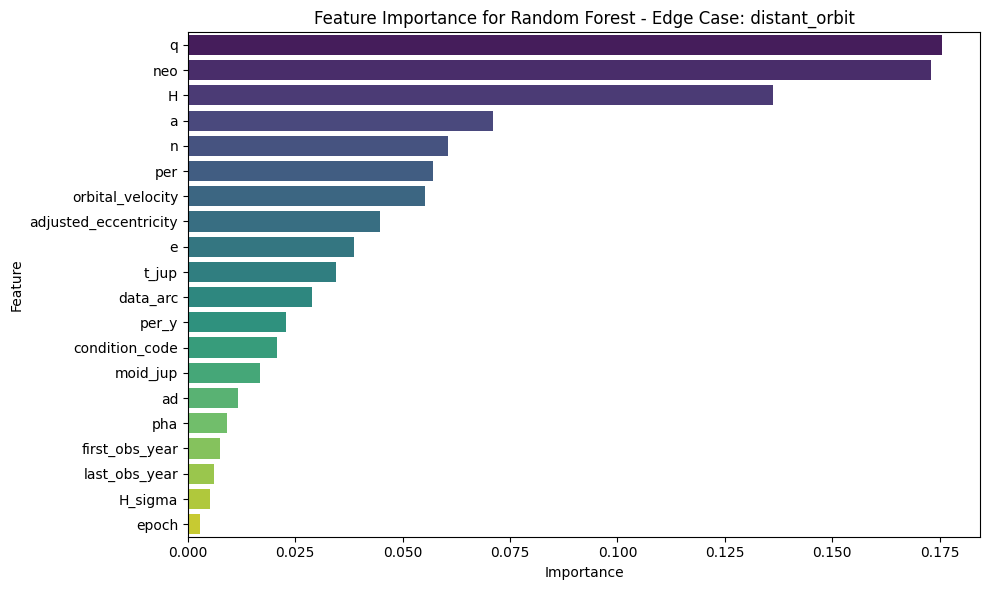

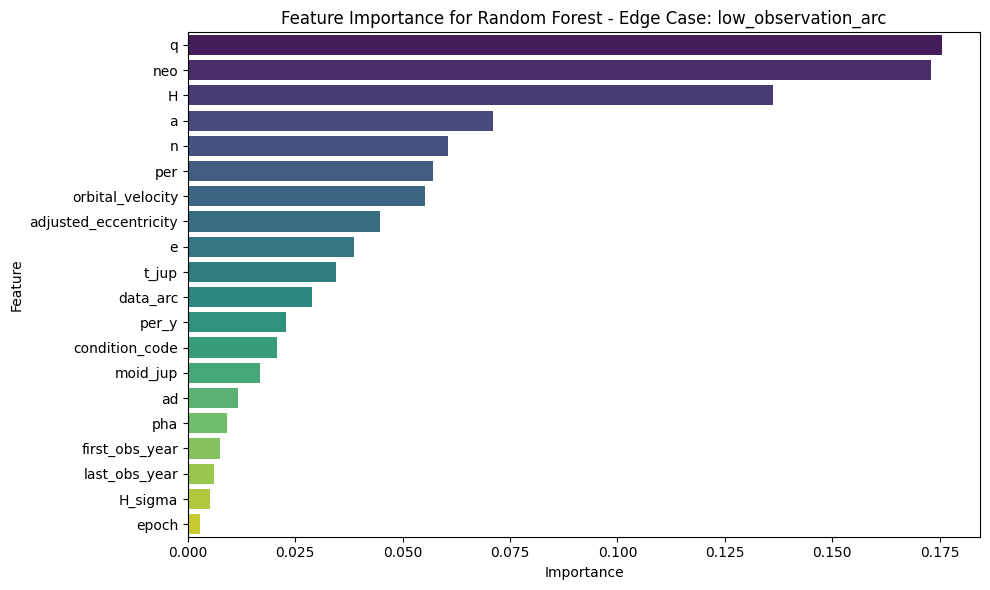

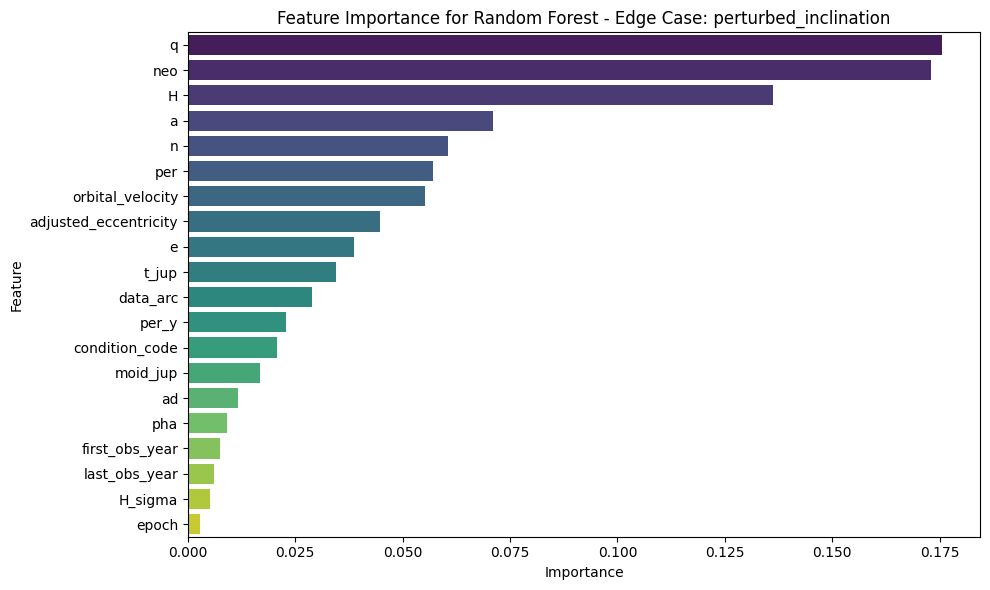

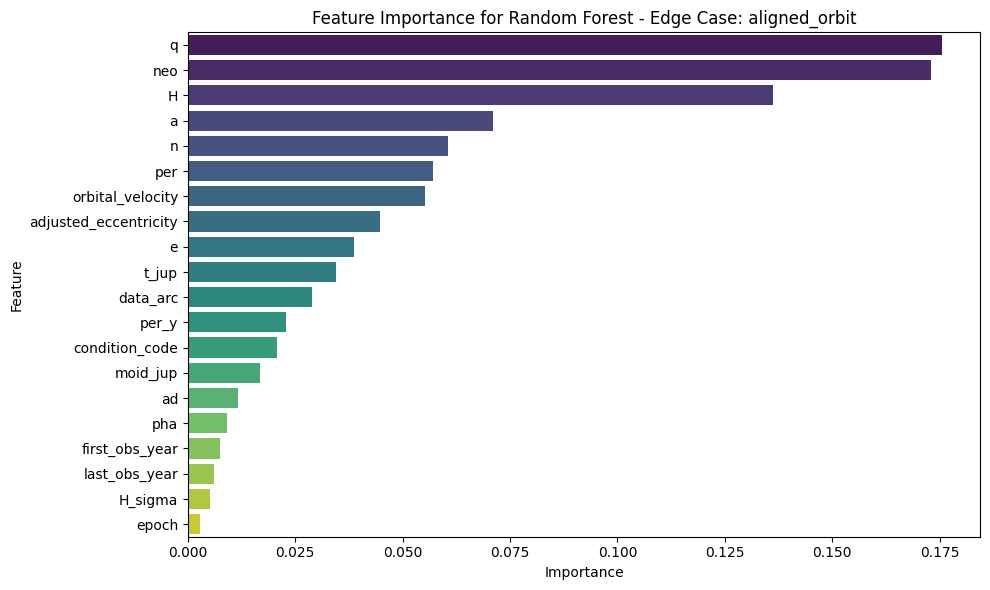

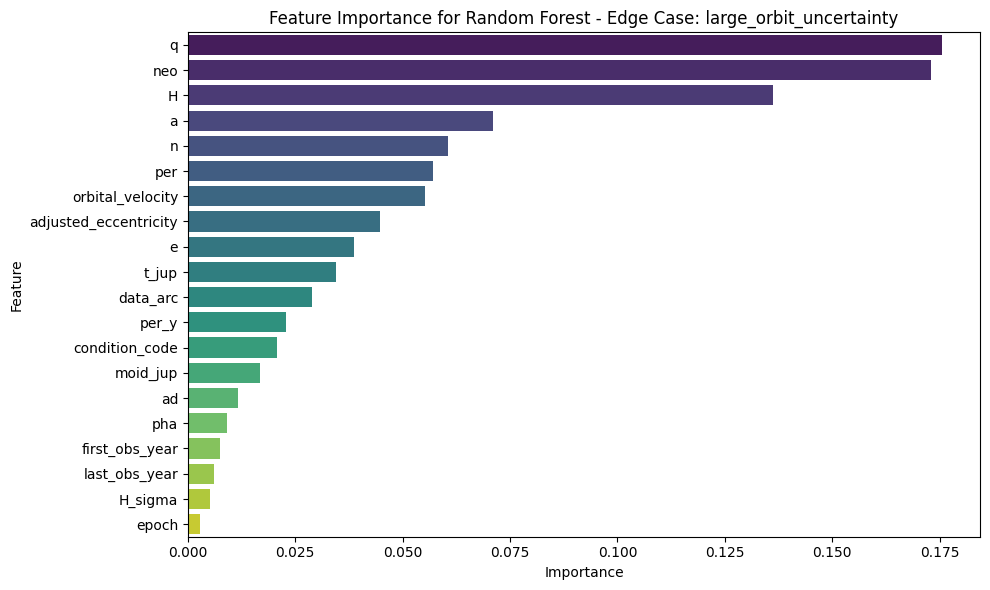

In [30]:
# Run Feature Importance Analysis for Random Forest Edge Cases
print("\nAnalyzing Feature Importance for Random Forest Edge Cases...")
feature_importance_analysis(rf_edge_case_results, "Random Forest", X_test.columns, SAVE_DIR)


Analyzing Feature Importance for XGBoost Edge Cases...


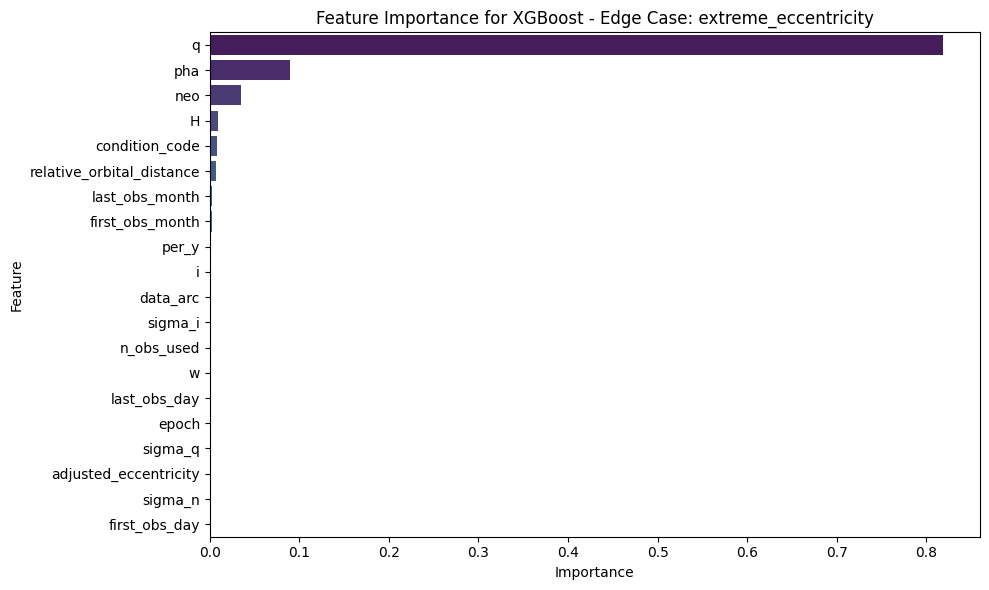

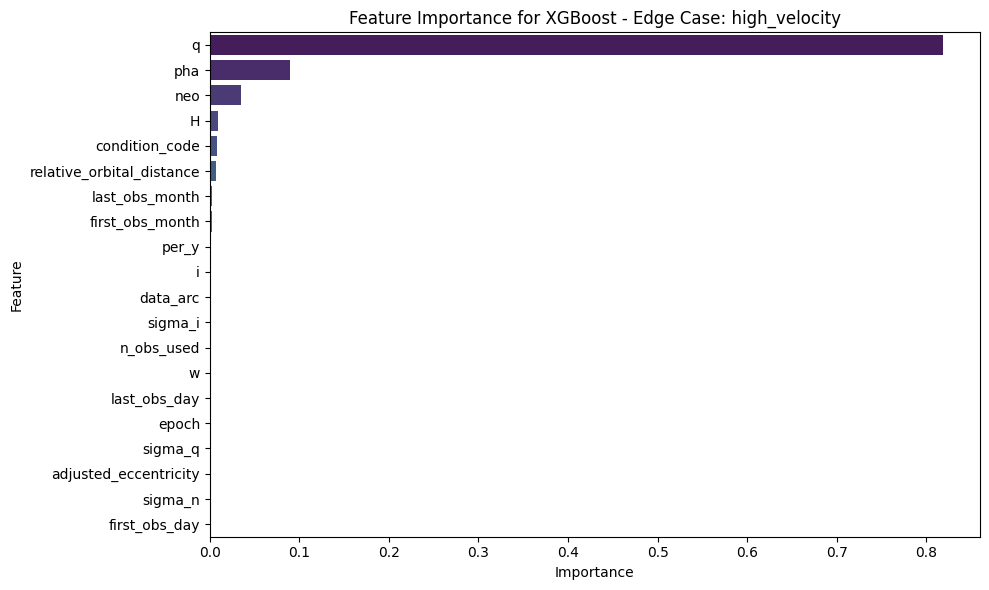

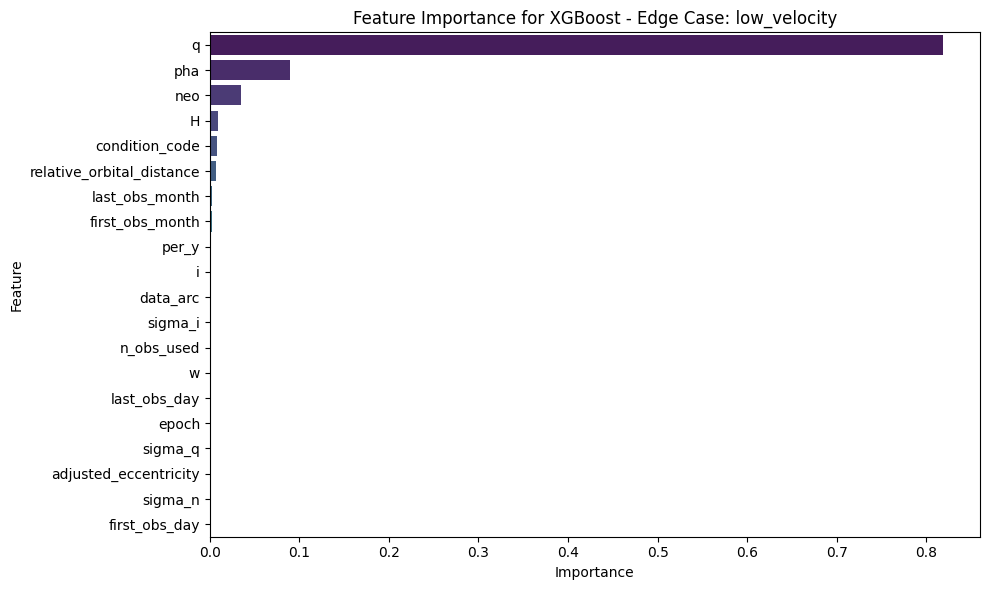

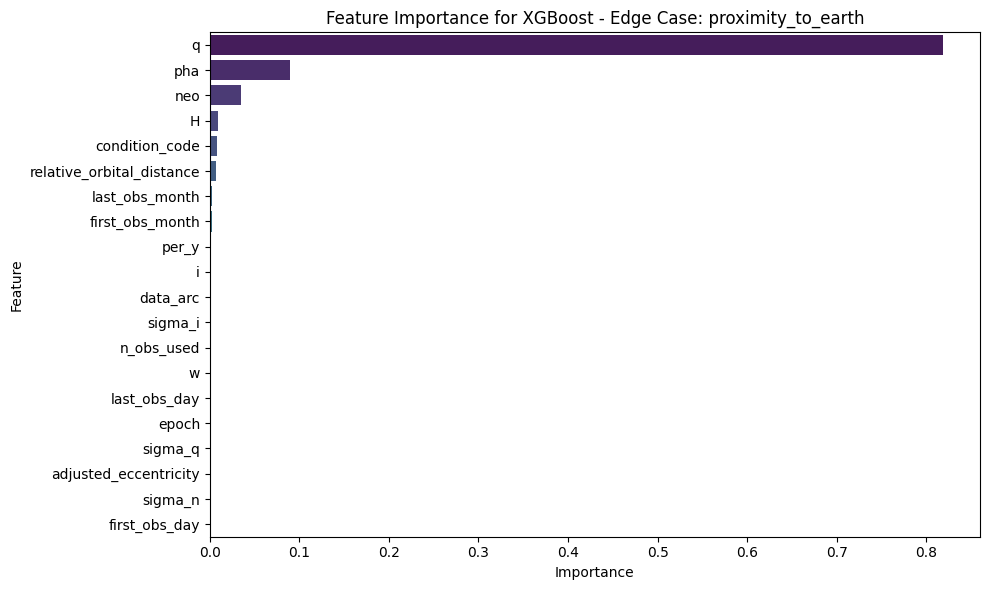

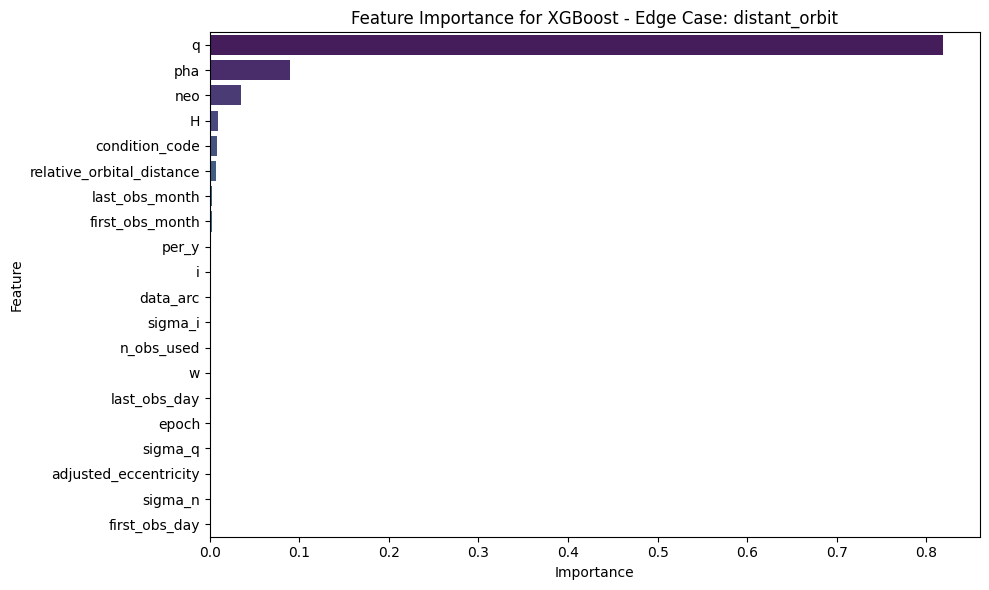

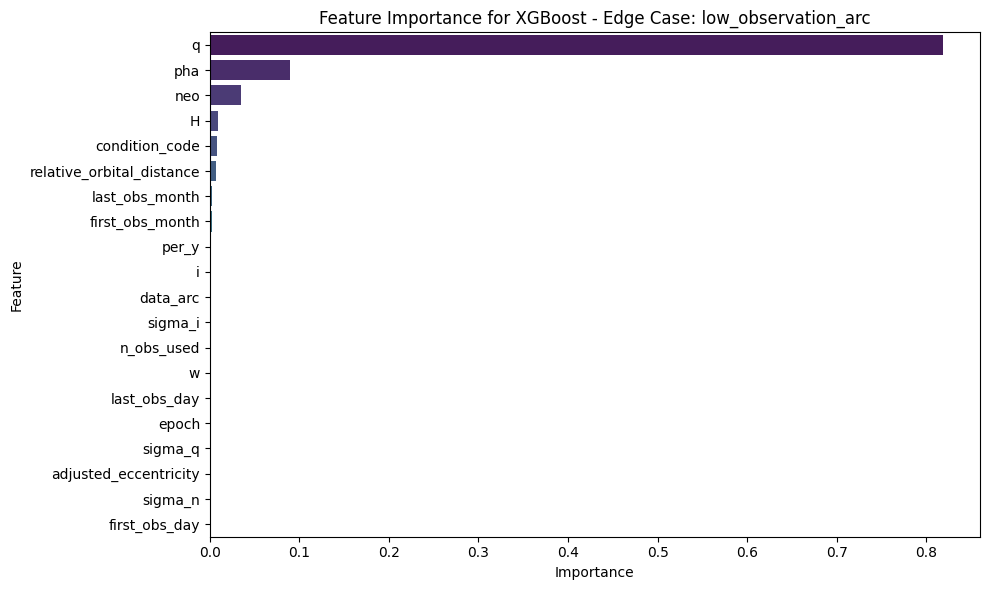

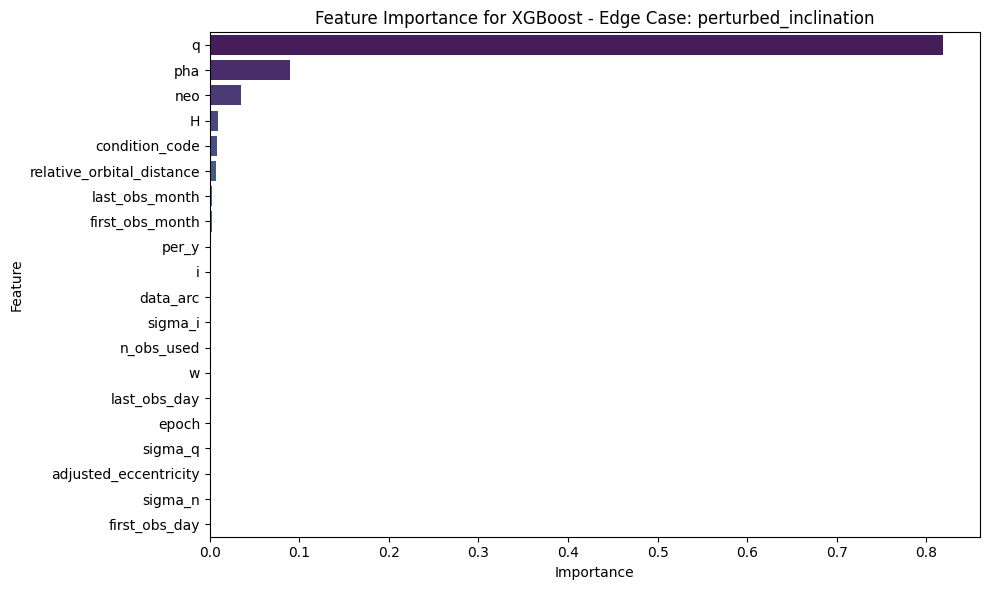

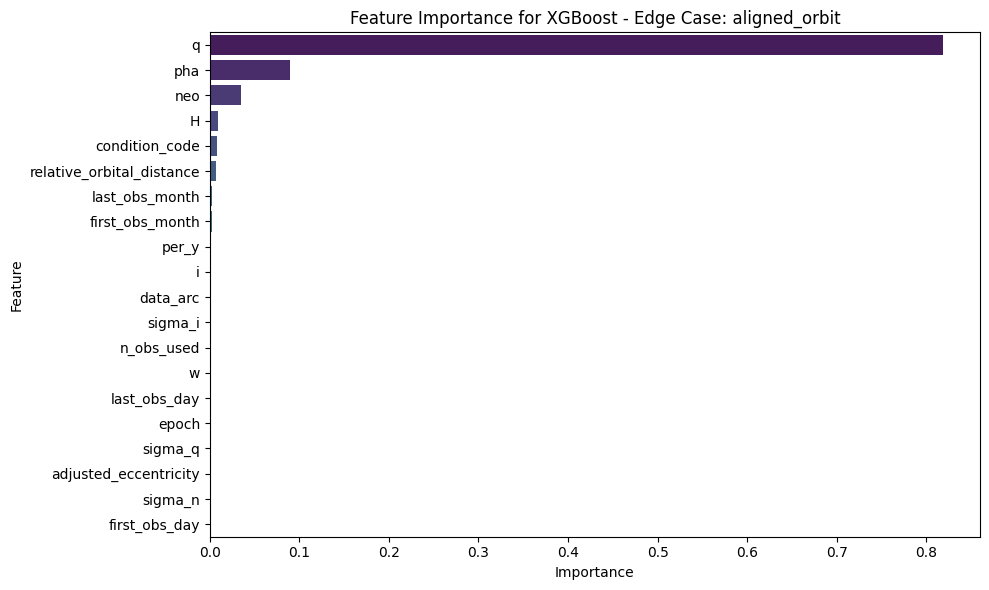

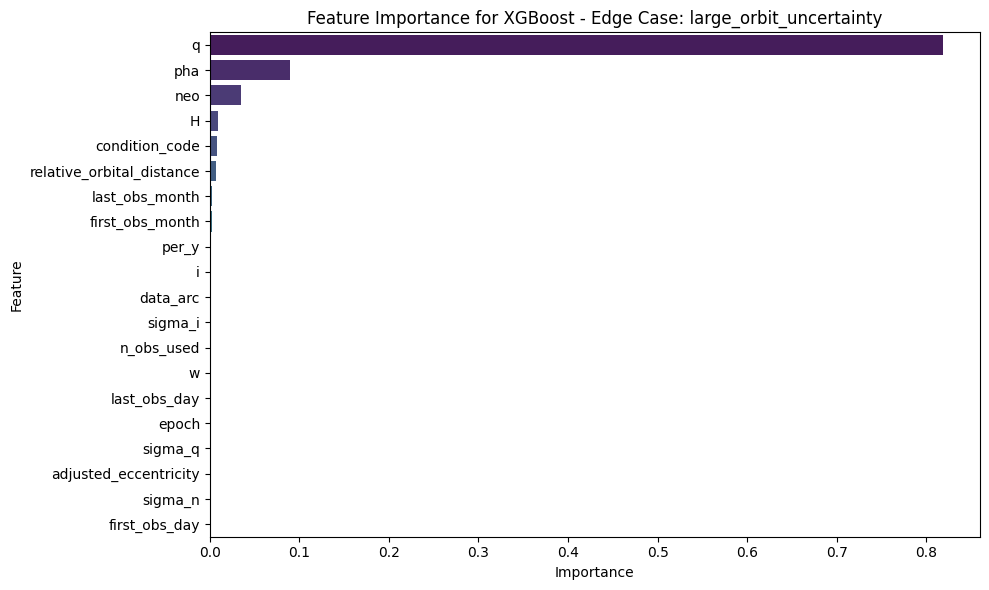

In [31]:
# Run Feature Importance Analysis for XGBoost Edge Cases
print("\nAnalyzing Feature Importance for XGBoost Edge Cases...")
feature_importance_analysis(xgb_edge_case_results, "XGBoost", X_test.columns, SAVE_DIR)

# 11.Model Interpretability with LIME

In [32]:
# Select a random instance to explain
instance_index = random.randint(0, X_test_scaled.shape[0] - 1)
instance_to_explain = X_test_scaled[instance_index]
logging.info(f"Selected instance index {instance_index} for LIME explanations.")

## 11.1 LIME for Random Forest

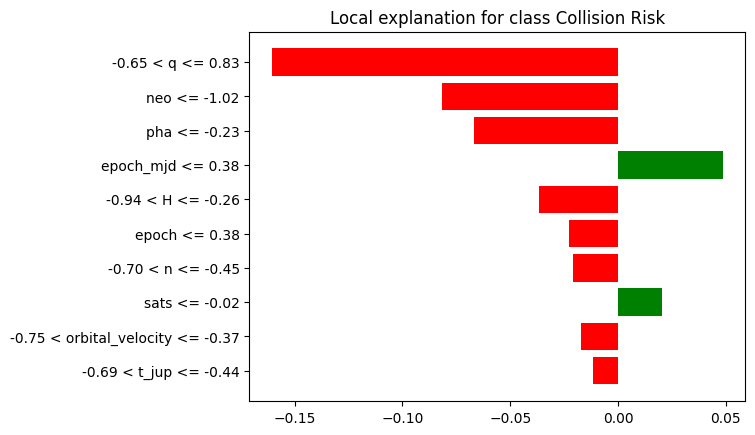

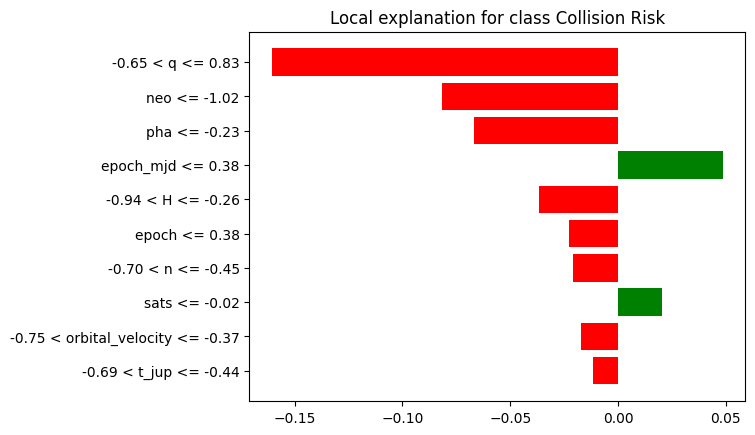

In [33]:
# LIME for Random Forest
def rf_predict_proba(data):
    return rf_model.predict_proba(data)

rf_lime_explainer = LimeTabularExplainer(
    training_data=X_train_resampled_scaled,
    mode="classification",
    feature_names=loaded_feature_names,
    class_names=["No Collision Risk", "Collision Risk"],
    discretize_continuous=True
)

rf_explanation = rf_lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=rf_predict_proba,
    num_features=10
)

# Save and display the explanation
rf_explanation.save_to_file(os.path.join(SAVE_DIR, 'rf_explanation.html'))
rf_explanation.show_in_notebook()
rf_explanation.as_pyplot_figure()

## 11.2 LIME for XGBoost

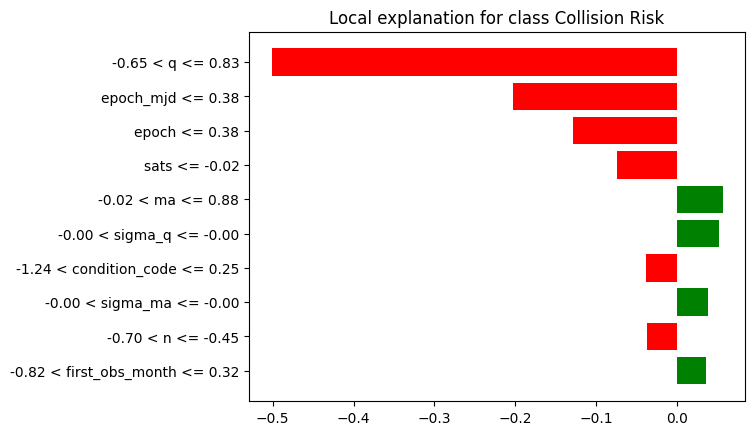

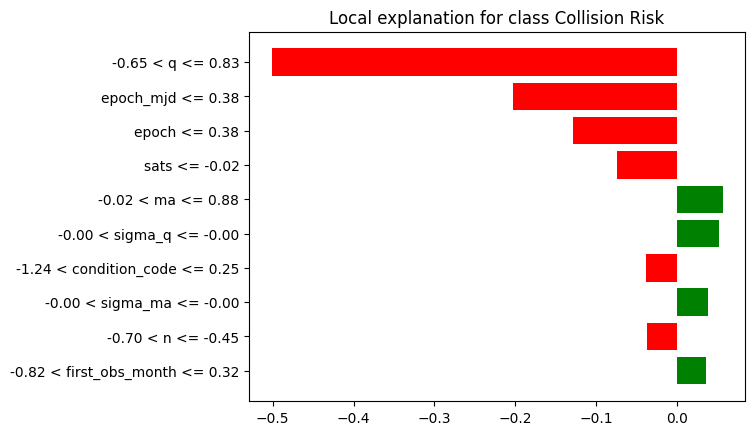

In [34]:
# LIME for XGBoost
def xgb_predict_proba(data):
    return xgb_model.predict_proba(data)

xgb_lime_explainer = LimeTabularExplainer(
    training_data=X_train_resampled_scaled,
    mode="classification",
    feature_names=loaded_feature_names,
    class_names=["No Collision Risk", "Collision Risk"],
    discretize_continuous=True
)

xgb_explanation = xgb_lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=xgb_predict_proba,
    num_features=10
)

# Save and display the explanation
xgb_explanation.save_to_file(os.path.join(SAVE_DIR, 'xgb_explanation.html'))
xgb_explanation.show_in_notebook()
xgb_explanation.as_pyplot_figure()

## 11.3 LIME for Neural Network

In [35]:
# LIME for Neural Network
def nn_predict_proba(data):
    class_1_prob = dense_model.predict(data).flatten()
    class_0_prob = 1 - class_1_prob
    return np.column_stack((class_0_prob, class_1_prob))

nn_lime_explainer = LimeTabularExplainer(
    training_data=X_train_resampled_scaled,
    mode="classification",
    feature_names=loaded_feature_names,
    class_names=["No Collision Risk", "Collision Risk"],
    discretize_continuous=True
)

nn_explanation = nn_lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=nn_predict_proba,
    num_features=10
)

# Save and display the explanation
nn_explanation.save_to_file(os.path.join(SAVE_DIR, 'nn_explanation.html'))
nn_explanation.show_in_notebook()
nn_explanation.as_pyplot_figure()

NameError: name 'dense_model' is not defined

# Conclusion

In [ ]:
logging.info("Script completed successfully.")
print("\nAsteroid Collision Risk Prediction workflow completed. All models trained, evaluated, and saved.")